# Main Script Airline Dataset

First all required packages are loaded.

Note, that only well known packages are used and all functions, methods or procedures applied are well described on the websited of the respective packages.

For this script to run, following files are required. All files are provided and can also be recreated using the data script.

- 'DataFrame'
- 'clean_data'
- 'adjacency_matrix.csv'
- 'test.csv'


In [2]:
# import all required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import networkx as nx
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import dgl
import dgl.nn as dglnn

import torch
import torch.nn as nn
import torch.nn.functional as F
from sage import SAGEConv

import tqdm

import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

Using backend: pytorch


The normalization function for scaling the data within the range between 1 - 5 is defined below

In [3]:
# used for scaling non-ordinal data within the range of 1 - 5 
def normalize(x):
    return (x-x.min())/(x.max()-x.min()) * (5-1) + 1

The following function is the L2-normalization applied in the GraphSage model

In [4]:
# l2 normalization of GNN layer outputs after activation function
def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

## Load and Inspect the Data

Below a general overview of the dataset is gained.

In [5]:
df = pd.read_csv('DataFrame')
X = pd.read_csv('clean_data')

In [6]:
df['Type of Travel'].value_counts(normalize=True)

Business travel    0.689167
Personal Travel    0.310833
Name: Type of Travel, dtype: float64

In [7]:
X.drop(columns=['Unnamed: 0'],inplace=True)
# Adjust coding of Class, such that range is from 1-3. Was 0-2 before for the MAG generation process
X.Class = X.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
X

Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  \
0          1              0   69               0      1              964   
1          0              0   55               1      3              240   
2          1              0   51               1      3             2672   
3          0              1   27               1      1              495   
4          0              0   12               0      1              462   
...      ...            ...  ...             ...    ...              ...   
5995       1              0   49               0      1             1587   
5996       1              0   33               0      1              588   
5997       0              0   50               0      1             2358   
5998       0              0   35               0      1              672   
5999       0              0   32               0      3              397   

      Inflight wifi service  Departure/Arrival time convenient  \
0                         3                                  2   
1                         2                                  5   
2                         5                                  5   
3                         2                                  3   
4                         2                                  4   
...                     ...                                ...   
5995                      3                                  4   
5996                      2                                  5   
5997                      1                                  4   
5998                      2                                  3   
5999                      3                                  4   

      Ease of Online booking  Gate location  ...  Seat comfort  \
0                          3              3  ...             2   
1                          5              5  ...             2   
2                          5              5  ...             1   
3                          2              2  ...             3   
4                          2              3  ...             2   
...                      ...            ...  ...           ...   
5995                       3              4  ...             5   
5996                       2              3  ...             5   
5997                       1              5  ...             4   
5998                       2              2  ...             5   
5999                       3              1  ...             4   

      Inflight entertainment  On-board service  Leg room service  \
0                          5                 5                 3   
1                          1                 1                 2   
2                          4                 4                 4   
3                          3                 4                 4   
4                          2                 3                 4   
...                      ...               ...               ...   
5995                       4                 4                 3   
5996                       5                 5                 3   
5997                       4                 4                 5   
5998                       5                 1                 1   
5999                       4                 4                 2   

      Baggage handling  Checkin service  Inflight service  Cleanliness  \
0                    5                1                 5            3   
1                    3                2                 3            2   
2                    4                5                 4            3   
3                    3                4                 2            3   
4                    2                2                 1            2   
...                ...              ...               ...          ...   
5995                 5                3                 4            5   
5996                 5                5                 5            5   
5997                 4  

In [8]:
# Distribution of Gender in the data
X.Gender.value_counts(normalize=True)

1    0.507667
0    0.492333
Name: Gender, dtype: float64

<Figure size 2160x2160 with 0 Axes>

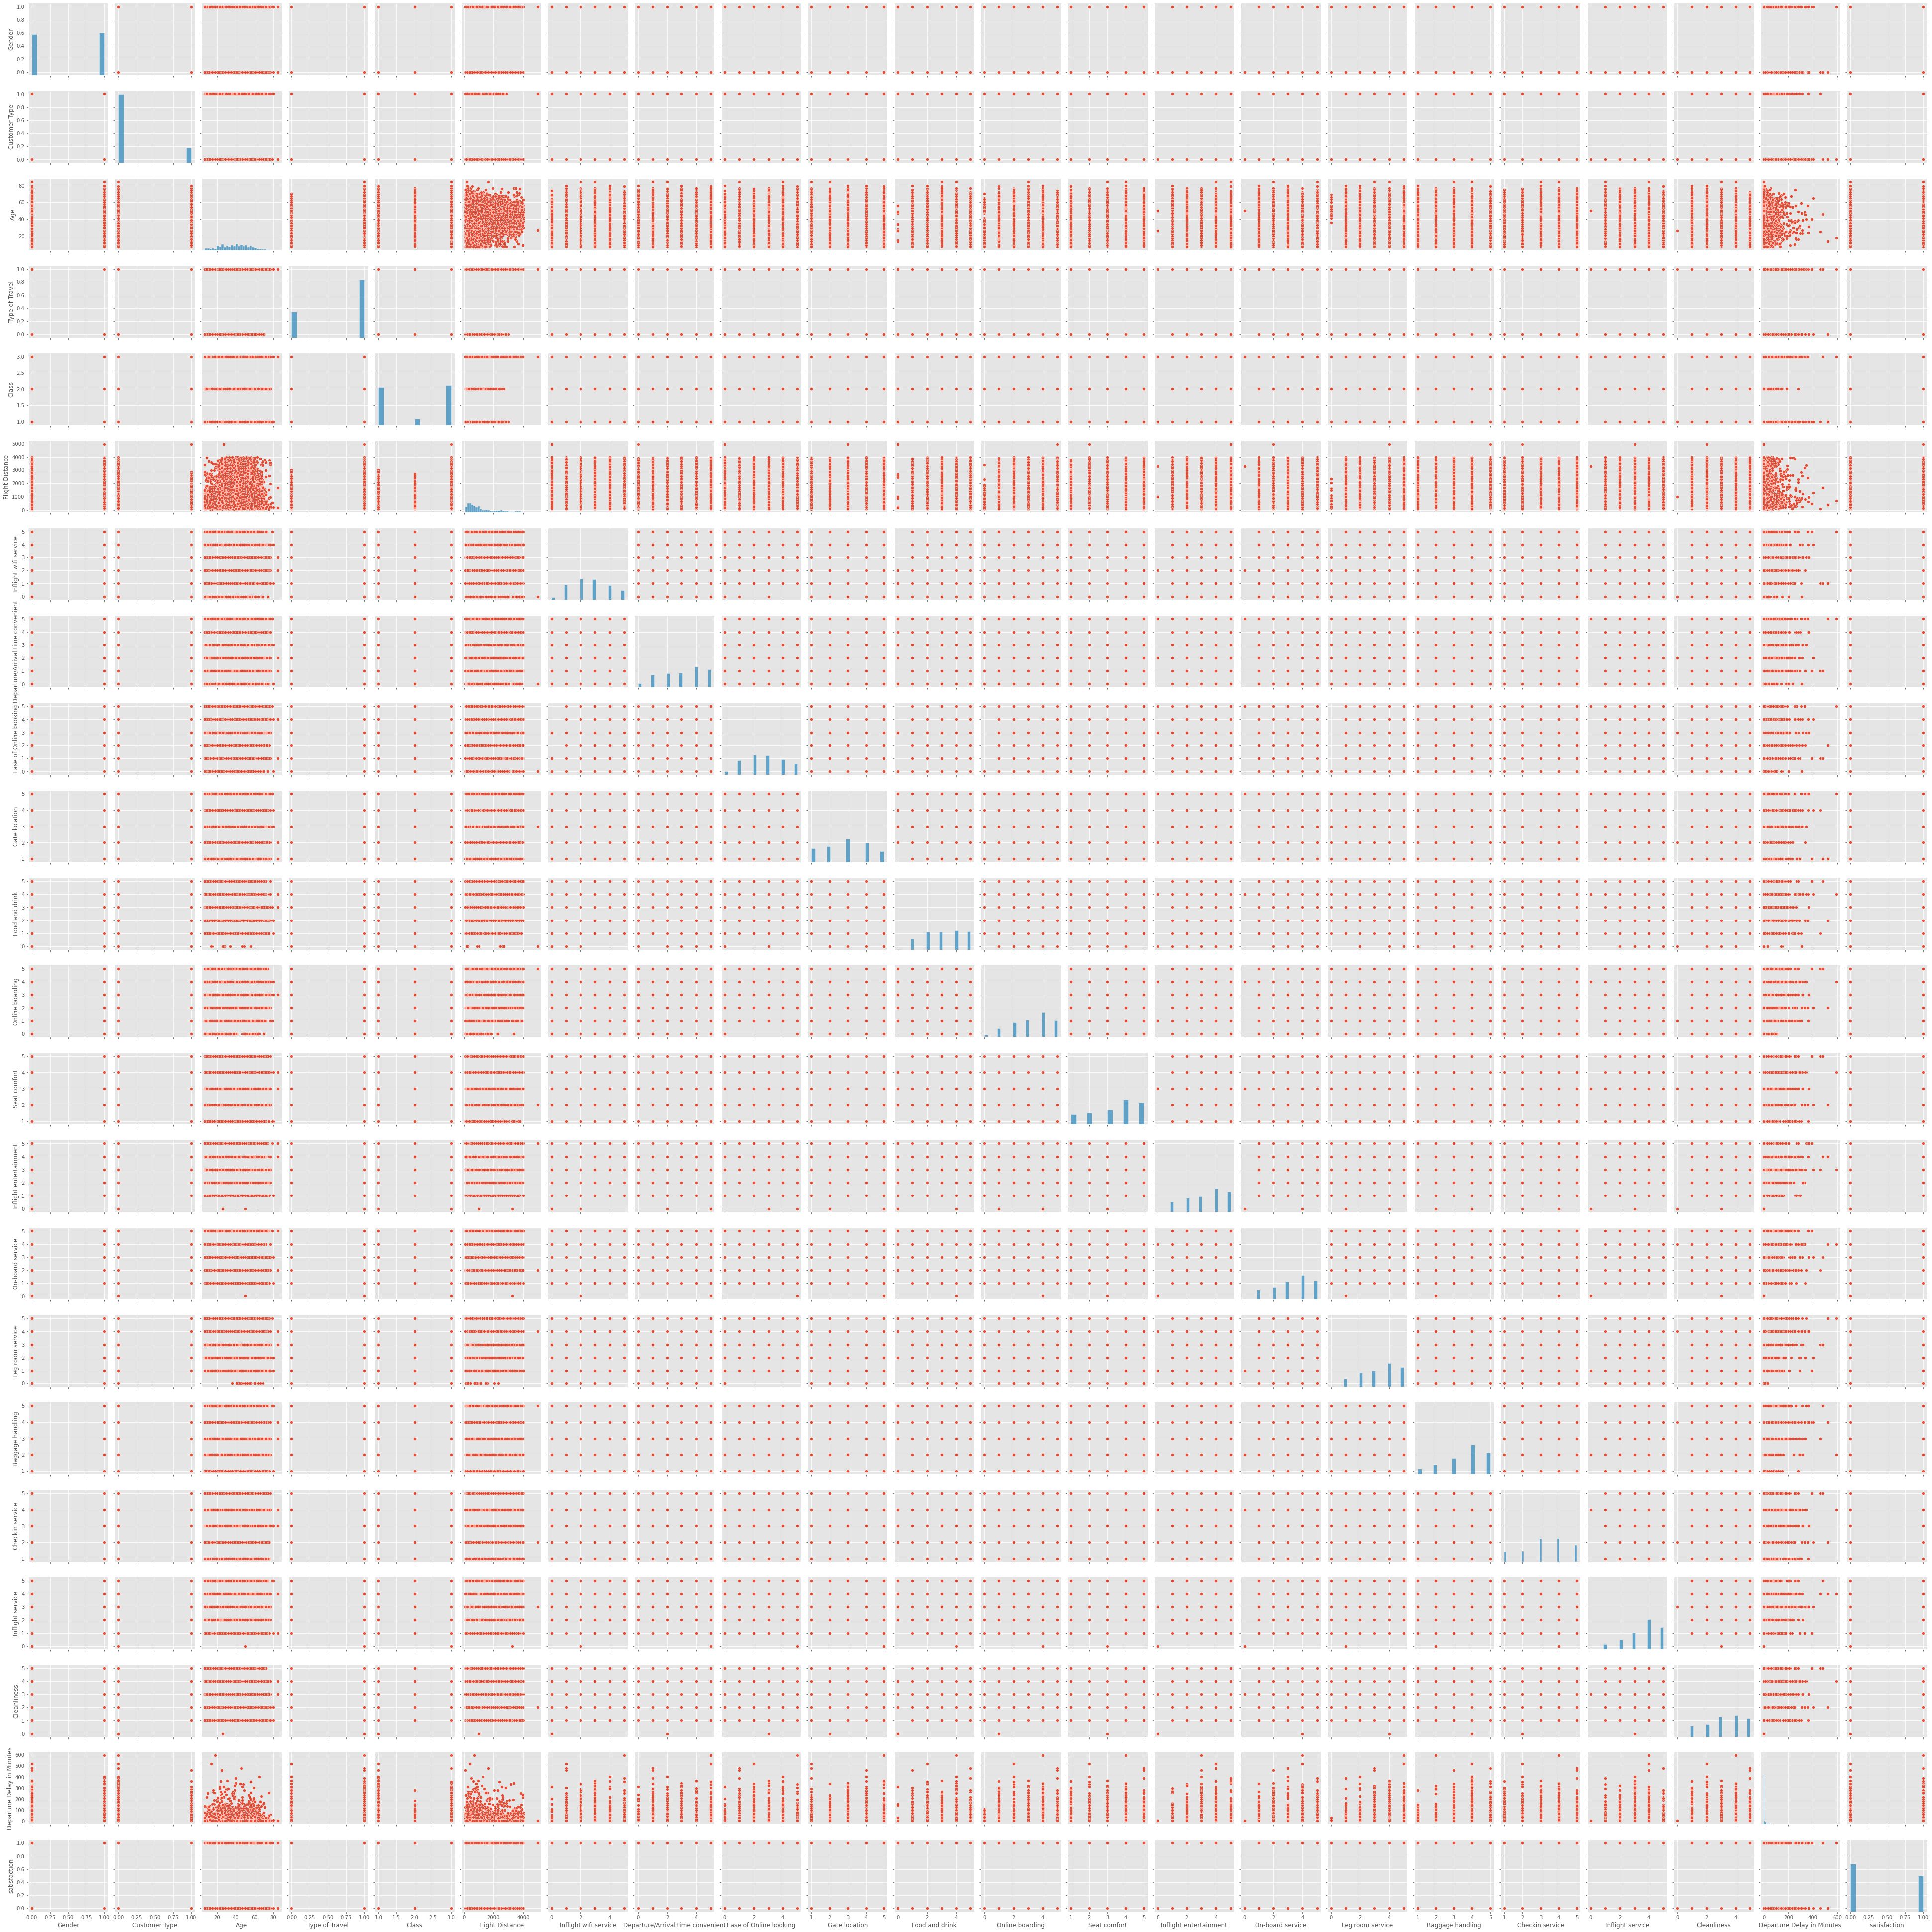

In [9]:
# Pairplot of ht entire dataset
plt.figure(figsize=(30,30))
sns.pairplot(X)
plt.show()

In [10]:
# Can be used to investigate the value counts for every category given the typ of travel
bus = (X['Type of Travel'] == 1)
pers = (X['Type of Travel'] == 0)
X[pers]['Gate location'].value_counts()

3    665
4    460
2    339
1    277
5    124
Name: Gate location, dtype: int64

In [11]:
X[bus]['satisfaction'].describe()

count    4135.000000
mean        0.578718
std         0.493824
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: satisfaction, dtype: float64

## Load the Graph Generated in The Data Script

In [12]:
A = np.loadtxt('adjacency_matrix.csv',delimiter=',')

In [13]:
np.diag(A).sum()

0.0

In [14]:
G = nx.from_numpy_matrix(A)

In [15]:
nx.is_connected(G)

True

## Dummy Code and Normalize the Data

In [16]:
features = pd.Series(X.satisfaction) # separate label from features
x_var = X.drop(columns=['satisfaction'])
x_wd = pd.get_dummies(data=x_var,columns=['Customer Type','Type of Travel','Gender'])
x_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(x_wd[['Age','Departure Delay in Minutes','Flight Distance']])

## Load and Pre-Process the Test Data in the exact same way as the Training Data

In [17]:
# Load Test Data
df_test = pd.read_csv('test.csv',sep=',')
df_test = df_test.sample(n=6000)
df_test.drop(columns=['Unnamed: 0','id'],inplace=True)
df_test.Gender = df_test.Gender.apply(lambda x: 0 if x == 'Male' else 1)
df_test['Customer Type'] = df_test['Customer Type'].apply(lambda x: 0 if x == 'Loyal Customer' else 1)
df_test['Type of Travel'] = df_test['Type of Travel'].apply(lambda x: 0 if x == 'Personal Travel' else 1)
df_test['Class'] = df_test['Class'].apply(lambda x: 0 if x == 'Eco' else(1 if x == 'Eco Plus' else 2))
df_test['satisfaction'] = df_test['satisfaction'].apply(lambda x: 0 if x == 'neutral or dissatisfied' else 1)
df_test.reset_index(drop=True,inplace=True)
df_test.drop(columns=['Arrival Delay in Minutes'],inplace = True)

In [18]:
TEST = df_test.copy(deep=True)

In [19]:
test_gen = TEST[['Gender','Customer Type','Age','Type of Travel','Class']].copy(deep=True)
test_gen.Age = test_gen.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [20]:
TEST.Class = TEST.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))

In [21]:
xx = TEST.drop(columns=['satisfaction'])
xx_dummy = pd.get_dummies(data=xx,columns=['Customer Type','Type of Travel','Gender'])
xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']])
yy = TEST.satisfaction

## Plot the Training- Validation Graph

In [62]:
pos = nx.spring_layout(G)

In [63]:
dissatisfied = df.index[df.satisfaction == 'neutral or dissatisfied'].tolist()
satisfied = df.index[df.satisfaction == 'satisfied'].tolist()

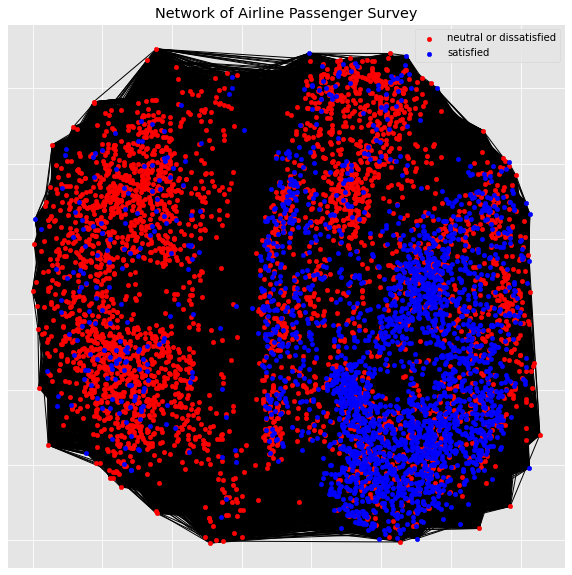

In [64]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r',label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b',label='satisfied')
nx.draw_networkx_edges(G,pos,label=None)
plt.title('Network of Airline Passenger Survey')
plt.legend()
plt.show()

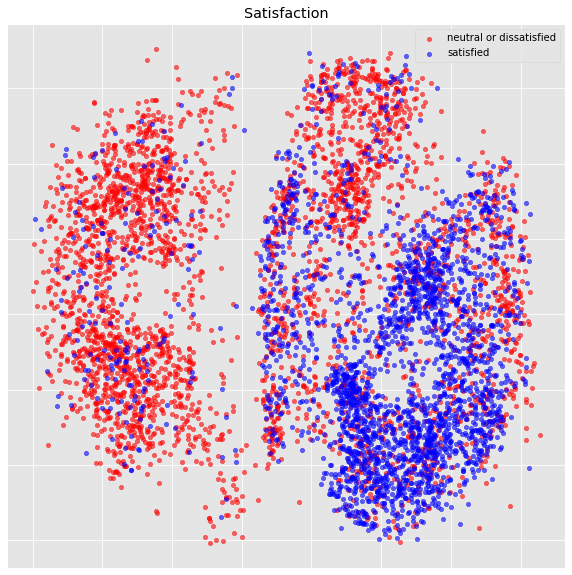

In [65]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.legend()
plt.title('Satisfaction')
plt.show()

<AxesSubplot:>

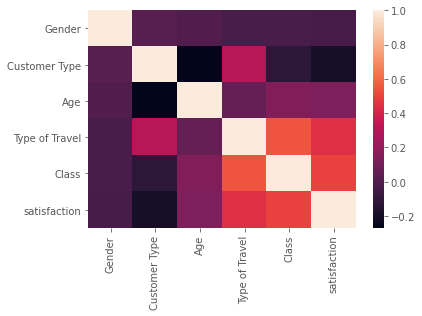

In [66]:
# correlation Map of the Attribute Variables and the Label
cormap_vars = X[['Gender','Customer Type','Age','Type of Travel','Class','satisfaction']]
cormap = cormap_vars.corr()
sns.heatmap(cormap)

In [67]:
male = df.index[df.Gender == 'Male'].tolist()
female = df.index[df.Gender == 'Female'].tolist()

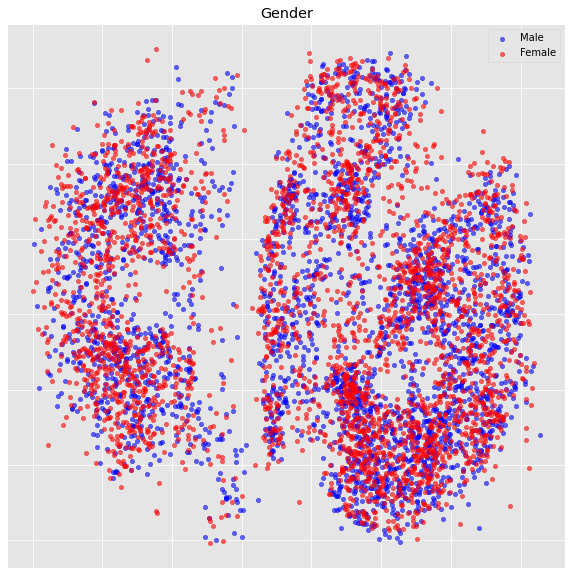

In [68]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.legend()
plt.title('Gender')
plt.show()

In [69]:
loyal = df.index[df['Customer Type'] == 'Loyal Customer'].tolist()
disloyal = df.index[df['Customer Type'] == 'disloyal Customer'].tolist()

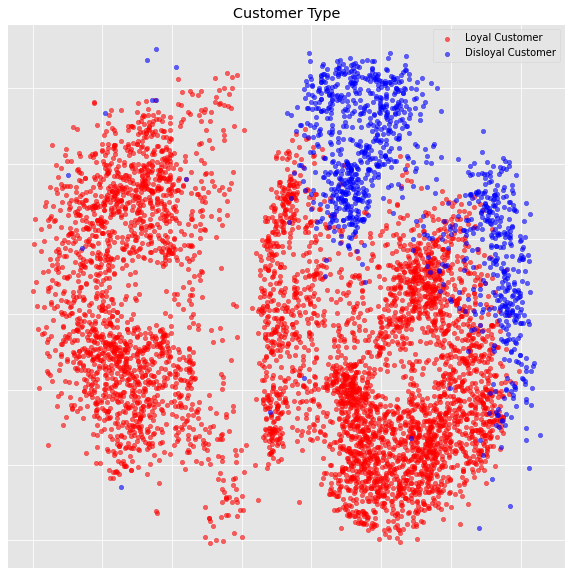

In [70]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.legend()
plt.title('Customer Type')
plt.show()

In [71]:
eco = df.index[df.Class == 'Eco'].tolist()
eco_plus = df.index[df.Class == 'Eco Plus'].tolist()
bus = df.index[df.Class == 'Business'].tolist()

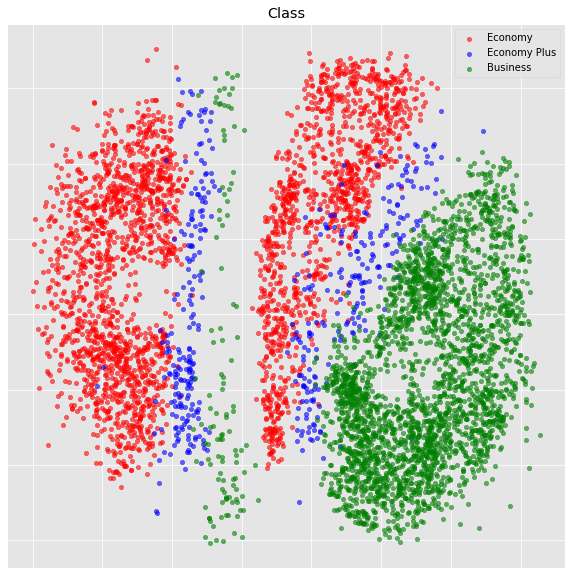

In [72]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.legend()
plt.title('Class')
plt.show()

In [73]:
personal = df.index[df['Type of Travel'] == 'Personal Travel'].tolist()
business = df.index[df['Type of Travel'] == 'Business travel'].tolist()

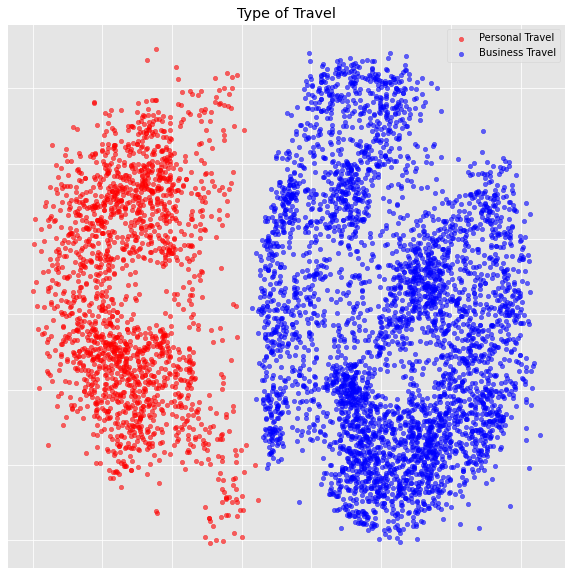

In [74]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.legend()
plt.title('Type of Travel')
plt.show()

In [75]:
AGE = df.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [76]:
age0 = AGE.index[AGE == 0].tolist()
age1 = AGE.index[AGE == 1].tolist()
age2 = AGE.index[AGE == 2].tolist()
age3 = AGE.index[AGE == 3].tolist()

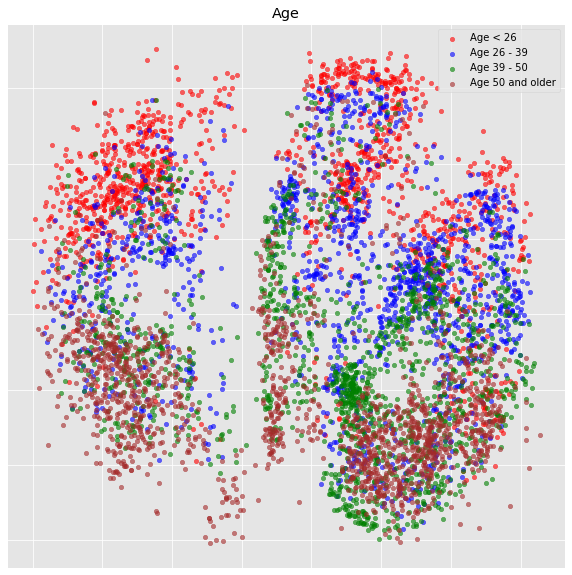

In [77]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older' )
plt.legend()
plt.title('Age')
plt.show()

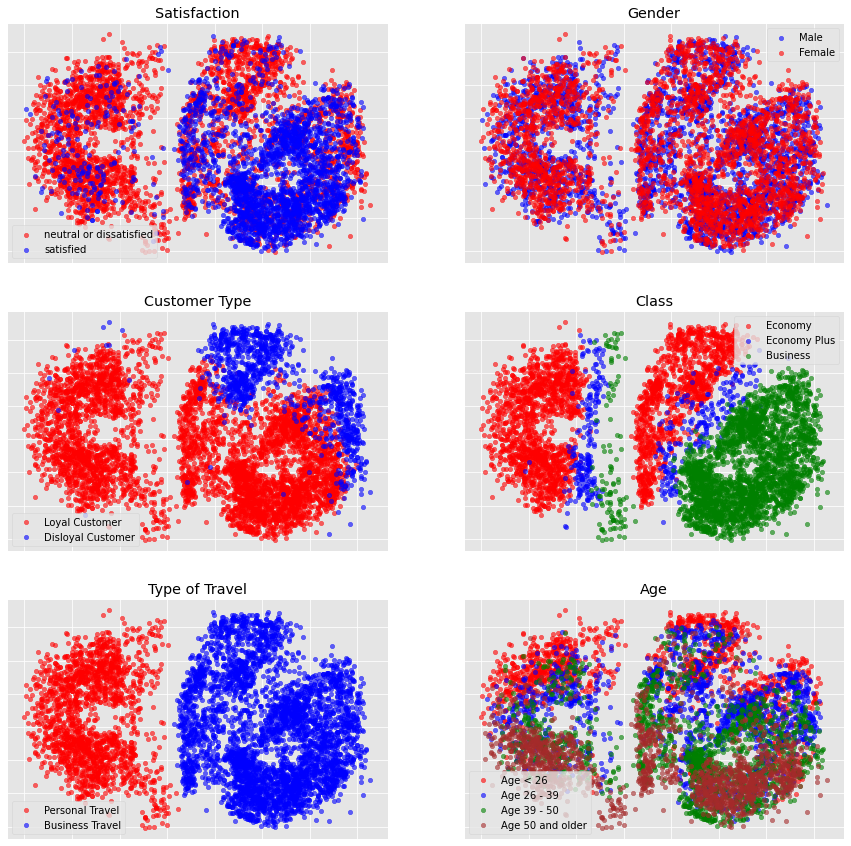

In [78]:
fig = plt.subplots(figsize=(15,15))

plt.subplot(321)
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.title('Satisfaction')
plt.legend()

plt.subplot(322)
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.title('Gender')
plt.legend()

plt.subplot(323)
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.title('Customer Type')
plt.legend()

plt.subplot(324)
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.title('Class')
plt.legend()

plt.subplot(325)
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.title('Type of Travel')
plt.legend()

plt.subplot(326)
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older')
plt.title('Age')
plt.legend()

plt.show()


## Assign the Graph Data to a dgl Graph and Prepare the Data for Machine Learning

In [22]:
G_dgl = dgl.from_networkx(G)

G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)
G_dgl.ndata['label'] = torch.tensor(features)

In [23]:
G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

In [24]:
node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [25]:
train_nodes = (train_mask == True).nonzero(as_tuple=False)
train_nids = torch.reshape(train_nodes,(-1,))
valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
valid_nids = torch.reshape(valid_nodes,(-1,))

In [26]:
len(train_nids)

4794

In [27]:
len(valid_nids)

1206

## Define the Dataloaders

In [28]:
batch_size = 50
sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10])
train_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, train_nids, sampler,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=0
)

In [29]:
example_minibatch = next(iter(train_dataloader))
print(example_minibatch)

[tensor([3622, 3494, 2364,  ..., 1331, 5095, 2874]), tensor([3622, 3494, 2364, 3080,  108, 4716,  192, 1978, 5791,   90, 5098, 1581,
        5202,  263, 2278, 3029, 1798,    1, 3394,  750, 1011, 2201,  224, 2818,
        5952, 3819, 4420, 1457, 1768, 5768, 3854, 4628, 4624, 5045, 2559, 3066,
        4698,  289, 1348, 3287,  812, 1524, 3724, 2547, 4278, 3418,  536, 5594,
        4309, 4889]), [Block(num_src_nodes=2433, num_dst_nodes=520, num_edges=2600), Block(num_src_nodes=520, num_dst_nodes=50, num_edges=500)]]


In [30]:
input_nodes, output_nodes, bipartites = example_minibatch
print("To compute {} nodes' output we need {} nodes' input features".format(len(output_nodes), len(input_nodes)))

To compute 50 nodes' output we need 2433 nodes' input features


In [31]:
print(bipartites)

[Block(num_src_nodes=2433, num_dst_nodes=520, num_edges=2600), Block(num_src_nodes=520, num_dst_nodes=50, num_edges=500)]


In [32]:
batch_size = len(valid_nids)
valid_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, valid_nids, sampler,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

## Define the GraphSage Model, Train and get Results

The aggregation types are named as follows:

- 'pool' = max-pooling
- 'mean' = mean aggregations
- 'lstm' = LSTM aggregation

For sum-pooling, the class SumSage is used where 'pool' refers to sum-pooling and makes used of the script in the file sage.py

Note, that the logSoftmax function is not defined in the Sage classes below for the final output layer. This is because, the logSoftmax function is automatically applied when calculating the loss using the F.cross_entropy function. For that reason, the logSoftmax function is applied separately in the training script for getting the predicted values. This is both true for the GraphSage and GCN models.

In [33]:
class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers,agg_type='pool'):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [34]:
## Used for sum-pooling
class SumSAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type='pool', bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
            
        return x

In [35]:
# choose between sumSage or the standard GraphSage models and define the optimizer

#model = SumSAGE(n_features, len(x_wd.T), n_labels, 2) #n_layers
model = SAGE(n_features, len(x_wd.T), n_labels, 2, agg_type='pool') #n_layers
opt = torch.optim.Adam(model.parameters(),lr=0.002)#deine optimizer

Below the GraphSage model is trained

In [36]:
# GraphSage
best_accuracy = 0
best_model_path = 'model.pt'
epoch_losses_train = []
plot_loss_valid = []
train_acc = []
valid_acc = []
dur = []

for epoch in range(400):
    t0 = time.time()
    model.train()
    loss_epoch = 0
    accuracy_epoch = 0
    for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
        inputs = node_features[input_nodes]
        labels = node_labels[output_nodes]
        logits = model(bipartites, inputs)
        predictions = F.log_softmax(logits,dim=1)

        loss = F.cross_entropy(logits, labels)
        loss_epoch += loss.detach().item()
        opt.zero_grad()
        loss.backward()
        opt.step()

        accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
        accuracy_epoch += accuracy
    accuracy_epoch /= (step + 1)
    loss_epoch /= (step + 1)
    epoch_losses_train.append(loss_epoch)
    train_acc.append(accuracy_epoch)
    print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
    model.eval()
    
    predictions = []
    labels = []
    with torch.no_grad():
        for input_nodes, output_nodes, bipartites in valid_dataloader:
            inputs = node_features[input_nodes]
            labels.append(node_labels[output_nodes].numpy())
            predictions.append(F.log_softmax(model(bipartites, inputs),dim=1).argmax(1).numpy())
            valid_logits = model(bipartites, inputs)
            valid_labels = node_labels[output_nodes]
            valid_loss = F.cross_entropy(valid_logits, valid_labels)

        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        
        accuracy = accuracy_score(labels, predictions)
        dur.append(time.time() - t0)
        print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
        valid_acc.append(accuracy.item())
        plot_loss_valid.append(valid_loss.item())
    
torch.save(model.state_dict(), best_model_path)


Epoch: 0, Training Accuracy: 0.632, Training Loss: 0.632
Epoch: 0, Validation Accuracy: 0.754, Validation Loss: 0.525, Time: 1.4934
Epoch: 1, Training Accuracy: 0.795, Training Loss: 0.473
Epoch: 1, Validation Accuracy: 0.795, Validation Loss: 0.463, Time: 1.6011
Epoch: 2, Training Accuracy: 0.826, Training Loss: 0.430
Epoch: 2, Validation Accuracy: 0.828, Validation Loss: 0.412, Time: 1.5654
Epoch: 3, Training Accuracy: 0.841, Training Loss: 0.401
Epoch: 3, Validation Accuracy: 0.830, Validation Loss: 0.404, Time: 1.5563
Epoch: 4, Training Accuracy: 0.842, Training Loss: 0.389
Epoch: 4, Validation Accuracy: 0.841, Validation Loss: 0.389, Time: 1.5356
Epoch: 5, Training Accuracy: 0.842, Training Loss: 0.382
Epoch: 5, Validation Accuracy: 0.836, Validation Loss: 0.383, Time: 1.6111
Epoch: 6, Training Accuracy: 0.847, Training Loss: 0.378
Epoch: 6, Validation Accuracy: 0.859, Validation Loss: 0.365, Time: 1.6719
Epoch: 7, Training Accuracy: 0.848, Training Loss: 0.374
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.931, Training Loss: 0.186
Epoch: 62, Validation Accuracy: 0.924, Validation Loss: 0.173, Time: 1.8385
Epoch: 63, Training Accuracy: 0.923, Training Loss: 0.190
Epoch: 63, Validation Accuracy: 0.934, Validation Loss: 0.169, Time: 1.8417
Epoch: 64, Training Accuracy: 0.929, Training Loss: 0.177
Epoch: 64, Validation Accuracy: 0.931, Validation Loss: 0.170, Time: 1.8417
Epoch: 65, Training Accuracy: 0.924, Training Loss: 0.193
Epoch: 65, Validation Accuracy: 0.934, Validation Loss: 0.168, Time: 1.8383
Epoch: 66, Training Accuracy: 0.931, Training Loss: 0.184
Epoch: 66, Validation Accuracy: 0.928, Validation Loss: 0.172, Time: 1.8345
Epoch: 67, Training Accuracy: 0.925, Training Loss: 0.190
Epoch: 67, Validation Accuracy: 0.939, Validation Loss: 0.162, Time: 1.8345
Epoch: 68, Training Accuracy: 0.928, Training Loss: 0.186
Epoch: 68, Validation Accuracy: 0.928, Validation Loss: 0.169, Time: 1.8525
Epoch: 69, Training Accuracy: 0.927, Training Loss: 0.185
Epoc

Epoch: 123, Training Accuracy: 0.942, Training Loss: 0.151
Epoch: 123, Validation Accuracy: 0.942, Validation Loss: 0.135, Time: 1.8909
Epoch: 124, Training Accuracy: 0.937, Training Loss: 0.162
Epoch: 124, Validation Accuracy: 0.946, Validation Loss: 0.138, Time: 1.8888
Epoch: 125, Training Accuracy: 0.941, Training Loss: 0.157
Epoch: 125, Validation Accuracy: 0.946, Validation Loss: 0.150, Time: 1.8874
Epoch: 126, Training Accuracy: 0.938, Training Loss: 0.162
Epoch: 126, Validation Accuracy: 0.930, Validation Loss: 0.167, Time: 1.8819
Epoch: 127, Training Accuracy: 0.937, Training Loss: 0.159
Epoch: 127, Validation Accuracy: 0.943, Validation Loss: 0.143, Time: 1.8766
Epoch: 128, Training Accuracy: 0.944, Training Loss: 0.150
Epoch: 128, Validation Accuracy: 0.946, Validation Loss: 0.133, Time: 1.8736
Epoch: 129, Training Accuracy: 0.940, Training Loss: 0.156
Epoch: 129, Validation Accuracy: 0.948, Validation Loss: 0.134, Time: 1.8760
Epoch: 130, Training Accuracy: 0.939, Training L

Epoch: 184, Training Accuracy: 0.942, Training Loss: 0.147
Epoch: 184, Validation Accuracy: 0.944, Validation Loss: 0.136, Time: 2.0292
Epoch: 185, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 185, Validation Accuracy: 0.945, Validation Loss: 0.130, Time: 2.0289
Epoch: 186, Training Accuracy: 0.940, Training Loss: 0.154
Epoch: 186, Validation Accuracy: 0.948, Validation Loss: 0.141, Time: 2.0282
Epoch: 187, Training Accuracy: 0.948, Training Loss: 0.141
Epoch: 187, Validation Accuracy: 0.943, Validation Loss: 0.134, Time: 2.0280
Epoch: 188, Training Accuracy: 0.946, Training Loss: 0.145
Epoch: 188, Validation Accuracy: 0.949, Validation Loss: 0.126, Time: 2.0294
Epoch: 189, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 189, Validation Accuracy: 0.950, Validation Loss: 0.133, Time: 2.0302
Epoch: 190, Training Accuracy: 0.945, Training Loss: 0.144
Epoch: 190, Validation Accuracy: 0.945, Validation Loss: 0.128, Time: 2.0298
Epoch: 191, Training Accuracy: 0.950, Training L

Epoch: 245, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 245, Validation Accuracy: 0.947, Validation Loss: 0.140, Time: 2.0697
Epoch: 246, Training Accuracy: 0.942, Training Loss: 0.139
Epoch: 246, Validation Accuracy: 0.947, Validation Loss: 0.138, Time: 2.0700
Epoch: 247, Training Accuracy: 0.947, Training Loss: 0.140
Epoch: 247, Validation Accuracy: 0.944, Validation Loss: 0.141, Time: 2.0706
Epoch: 248, Training Accuracy: 0.946, Training Loss: 0.147
Epoch: 248, Validation Accuracy: 0.944, Validation Loss: 0.135, Time: 2.0754
Epoch: 249, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 249, Validation Accuracy: 0.945, Validation Loss: 0.122, Time: 2.0755
Epoch: 250, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 250, Validation Accuracy: 0.945, Validation Loss: 0.132, Time: 2.0765
Epoch: 251, Training Accuracy: 0.942, Training Loss: 0.155
Epoch: 251, Validation Accuracy: 0.941, Validation Loss: 0.150, Time: 2.0808
Epoch: 252, Training Accuracy: 0.945, Training L

Epoch: 306, Training Accuracy: 0.949, Training Loss: 0.136
Epoch: 306, Validation Accuracy: 0.944, Validation Loss: 0.128, Time: 2.0703
Epoch: 307, Training Accuracy: 0.944, Training Loss: 0.141
Epoch: 307, Validation Accuracy: 0.948, Validation Loss: 0.130, Time: 2.0701
Epoch: 308, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 308, Validation Accuracy: 0.944, Validation Loss: 0.128, Time: 2.0684
Epoch: 309, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 309, Validation Accuracy: 0.944, Validation Loss: 0.143, Time: 2.0673
Epoch: 310, Training Accuracy: 0.944, Training Loss: 0.143
Epoch: 310, Validation Accuracy: 0.946, Validation Loss: 0.130, Time: 2.0682
Epoch: 311, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 311, Validation Accuracy: 0.941, Validation Loss: 0.145, Time: 2.0663
Epoch: 312, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 312, Validation Accuracy: 0.946, Validation Loss: 0.134, Time: 2.0647
Epoch: 313, Training Accuracy: 0.947, Training L

Epoch: 367, Training Accuracy: 0.944, Training Loss: 0.143
Epoch: 367, Validation Accuracy: 0.948, Validation Loss: 0.129, Time: 2.0976
Epoch: 368, Training Accuracy: 0.949, Training Loss: 0.136
Epoch: 368, Validation Accuracy: 0.949, Validation Loss: 0.120, Time: 2.0967
Epoch: 369, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 369, Validation Accuracy: 0.948, Validation Loss: 0.127, Time: 2.0949
Epoch: 370, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 370, Validation Accuracy: 0.946, Validation Loss: 0.131, Time: 2.0932
Epoch: 371, Training Accuracy: 0.951, Training Loss: 0.139
Epoch: 371, Validation Accuracy: 0.945, Validation Loss: 0.127, Time: 2.0918
Epoch: 372, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 372, Validation Accuracy: 0.943, Validation Loss: 0.137, Time: 2.0932
Epoch: 373, Training Accuracy: 0.951, Training Loss: 0.130
Epoch: 373, Validation Accuracy: 0.948, Validation Loss: 0.132, Time: 2.0938
Epoch: 374, Training Accuracy: 0.948, Training L

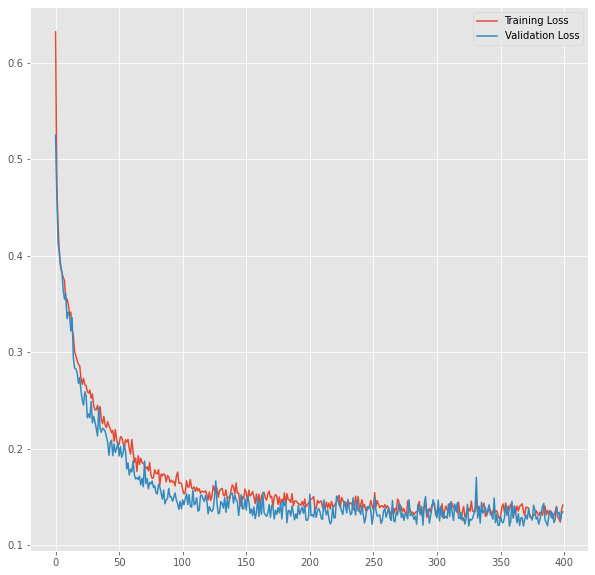

In [37]:
plt.figure(figsize=(10,10))
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.legend()
plt.show()

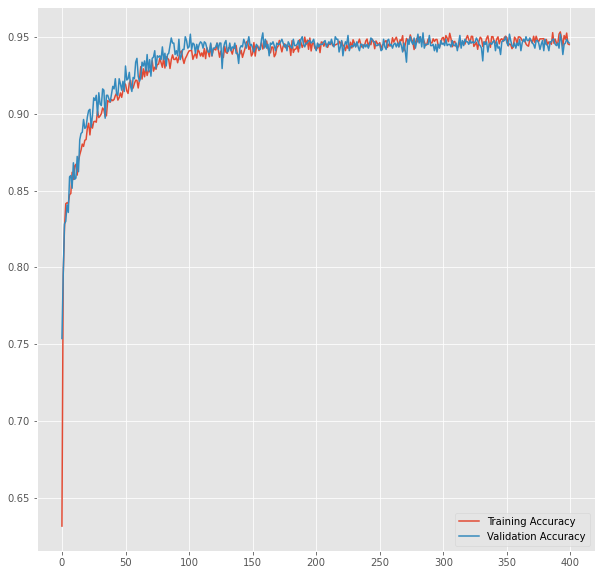

In [38]:
plt.figure(figsize=(10,10))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend()
plt.show()

In [39]:
print('Training Accuracy: {}'.format(train_acc[-1]))
print('Validation Accuracy: {}'.format(valid_acc[-1]))

Training Accuracy: 0.9451231060606053
Validation Accuracy: 0.9461028192371476


In [40]:
np.argmax(valid_acc)

158

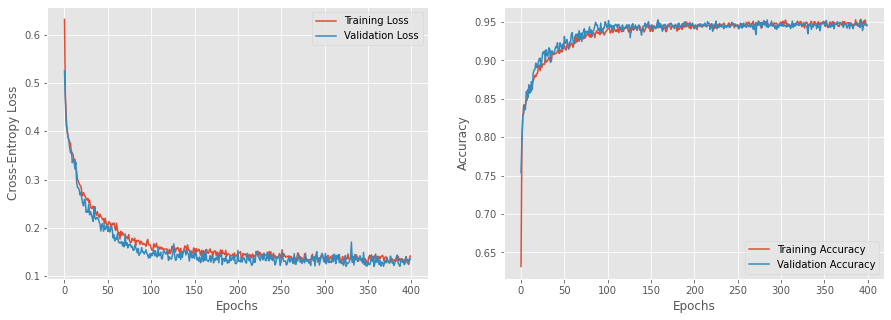

In [41]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [42]:
# shows the model parameters of the GraphSage model
model.parameters

<bound method Module.parameters of SAGE(
  (layers): ModuleList(
    (0): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (activation): ReLU()
      (fc_pool): Linear(in_features=24, out_features=24, bias=True)
      (fc_self): Linear(in_features=24, out_features=24, bias=False)
      (fc_neigh): Linear(in_features=24, out_features=24, bias=False)
    )
    (1): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (fc_pool): Linear(in_features=24, out_features=24, bias=True)
      (fc_self): Linear(in_features=24, out_features=2, bias=False)
      (fc_neigh): Linear(in_features=24, out_features=2, bias=False)
    )
  )
)>

## Graph Convolutional Network

Below the dgl data is reset to 30% training and 70 validation data which is then used for the GCN.

In [43]:
G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.3)
G_dgl.ndata['label'] = torch.tensor(features)

G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

Define the GCN network

In [44]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.pytorch.conv.GraphConv(
            in_feats=in_feats, out_feats=hid_feats,norm='both', weight=True, bias=True, activation=nn.ReLU(inplace=False))
        
        self.conv2 = dglnn.pytorch.conv.GraphConv(
            in_feats=hid_feats, out_feats=out_feats,norm='both', weight=True, bias=True, activation=None)
        
    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        h = self.conv2(graph, h)
        return h

Compile the model

In [45]:
model_gcn = GCN(n_features, len(x_wd.T) , n_labels) # 
opt = torch.optim.Adam(model_gcn.parameters(),lr=0.002)#GCN

In [46]:
def evaluate(model_gcn, graph, features, labels, mask):
    model_gcn.eval()
    with torch.no_grad():
        logits = model_gcn(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        preds = F.log_softmax(logits,dim=1)
        _, indices = torch.max(preds, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

Train the model

In [47]:
#model = GCN(in_feats=n_features, hid_feats_1=128, hid_feats_2=128, out_feats=n_labels)
#opt = torch.optim.Adam(model.parameters(),lr=1e-2)
plot_loss_train = []
plot_loss_val = []
valid_acc = []
train_acc = []
dur = []
for epoch in range(1000):
    t0 = time.time()
    model_gcn.train()
    # forward propagation by using all nodes
    logits = model_gcn(G_dgl, node_features)
    # compute loss
    loss_train = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    acc_train = evaluate(model_gcn, G_dgl, node_features, node_labels, train_mask)
    train_acc.append(acc_train)
    plot_loss_train.append(loss_train.item())
    opt.zero_grad()
    loss_train.backward()
    opt.step()
    
    model_gcn.eval()
    
    # compute validation accuracy
    with torch.no_grad():
        acc_val = evaluate(model_gcn, G_dgl, node_features, node_labels, valid_mask)
        loss_val = F.cross_entropy(logits[valid_mask], node_labels[valid_mask])
        valid_acc.append(acc_val)
        plot_loss_val.append(loss_val.item())
    # backward propagation
    
    dur.append(time.time() - t0)
    if epoch % 10 == 0:
        print('Epoch: {}, train loss: {:.4f}, validation loss: {:.4f}, training accuracy: {:.4f}, validation accuracy: {:.4f}, Time: {:.4f}'.format(epoch,loss_train.item(),loss_val.item(),acc_train,acc_val,np.mean(dur)))


Epoch: 0, train loss: 0.7567, validation loss: 0.7527, training accuracy: 0.5689, validation accuracy: 0.5712, Time: 0.8643
Epoch: 10, train loss: 0.6715, validation loss: 0.6713, training accuracy: 0.5904, validation accuracy: 0.5712, Time: 0.6058
Epoch: 20, train loss: 0.6633, validation loss: 0.6629, training accuracy: 0.5689, validation accuracy: 0.5712, Time: 0.5339
Epoch: 30, train loss: 0.6558, validation loss: 0.6551, training accuracy: 0.5689, validation accuracy: 0.5712, Time: 0.4614
Epoch: 40, train loss: 0.6463, validation loss: 0.6462, training accuracy: 0.7802, validation accuracy: 0.6870, Time: 0.4360
Epoch: 50, train loss: 0.6363, validation loss: 0.6363, training accuracy: 0.7718, validation accuracy: 0.7626, Time: 0.4248
Epoch: 60, train loss: 0.6260, validation loss: 0.6261, training accuracy: 0.7751, validation accuracy: 0.7619, Time: 0.4194
Epoch: 70, train loss: 0.6152, validation loss: 0.6156, training accuracy: 0.7819, validation accuracy: 0.7636, Time: 0.3980
E

Epoch: 660, train loss: 0.4840, validation loss: 0.4971, training accuracy: 0.7802, validation accuracy: 0.7589, Time: 0.3895
Epoch: 670, train loss: 0.4837, validation loss: 0.4968, training accuracy: 0.7785, validation accuracy: 0.7589, Time: 0.3904
Epoch: 680, train loss: 0.4835, validation loss: 0.4967, training accuracy: 0.7785, validation accuracy: 0.7589, Time: 0.3911
Epoch: 690, train loss: 0.4833, validation loss: 0.4965, training accuracy: 0.7780, validation accuracy: 0.7593, Time: 0.3922
Epoch: 700, train loss: 0.4832, validation loss: 0.4964, training accuracy: 0.7780, validation accuracy: 0.7593, Time: 0.3933
Epoch: 710, train loss: 0.4832, validation loss: 0.4964, training accuracy: 0.7791, validation accuracy: 0.7589, Time: 0.3939
Epoch: 720, train loss: 0.4829, validation loss: 0.4962, training accuracy: 0.7785, validation accuracy: 0.7600, Time: 0.3943
Epoch: 730, train loss: 0.4828, validation loss: 0.4961, training accuracy: 0.7785, validation accuracy: 0.7586, Time:

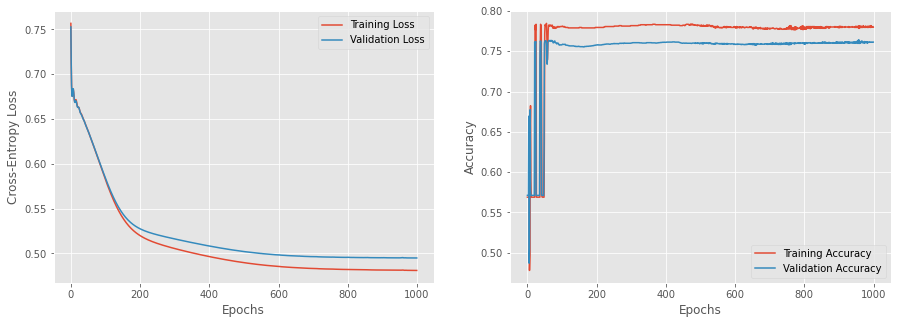

In [48]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(plot_loss_train,label='Training Loss')
plt.plot(plot_loss_val,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(valid_acc,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [49]:
val_tens = torch.tensor(features)
_, indices_val = torch.max(logits[valid_mask], dim=1)
val_lab = val_tens[valid_mask]
train_lab = val_tens[train_mask]
_, indices_train = torch.max(logits[train_mask], dim=1)

print('Classification Accuracy validation set {}'.format(accuracy_score(val_lab,indices_val)))
print('-------------------------------------------------------------')
print('Classification Accuracy training set {}'.format(accuracy_score(train_lab,indices_train)))
print('-------------------------------------------------------------')
print('Confusion Matrix validation set:')
print(confusion_matrix(val_lab, indices_val))
print('-------------------------------------------------------------')
print('Confusion Matrix training set:')
print(confusion_matrix(train_lab,indices_train))


Classification Accuracy validation set 0.7614657210401892
-------------------------------------------------------------
Classification Accuracy training set 0.7802259887005649
-------------------------------------------------------------
Confusion Matrix validation set:
[[1857  559]
 [ 450 1364]]
-------------------------------------------------------------
Confusion Matrix training set:
[[793 214]
 [175 588]]


In [50]:
model_gcn.parameters

<bound method Module.parameters of GCN(
  (conv1): GraphConv(
    in=24, out=24, normalization=both
    (_activation): ReLU()
  )
  (conv2): GraphConv(in=24, out=2, normalization=both, activation=None)
)>

## Generate Test Graph

Based on the test data, a new test graph is generated. This is the same procedure as is done in the the data script. It is repeated here for the test graph so that every A-Z simulation contains a new test graph. This ensures, that there is not some graph sampling bias. Note, different training graphs were tested as well. The results are consistent regardless of the generated graph.

In [51]:
# gender
gend_alpha0 = 0.60
gend_beta1 = 0.40

aff_gend = np.array([[gend_alpha0,gend_beta1],
                     [gend_beta1,gend_alpha0]])

# customer type (loyal vs disoyal)

type_alpha0 = 0.8
type_beta1 = 0.5

aff_type = np.array([[type_alpha0, type_beta1],
                     [type_beta1, type_alpha0]])


# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta3,age_beta2,age_beta1,age_alpha0]])


# Type of travel
trav_type_alpha0 = 0.80
trav_type_beta1 = 0.20

aff_trav_type = np.array([[trav_type_alpha0, trav_type_beta1],
                          [trav_type_beta1, trav_type_alpha0]])

# Class

class_alpha0 = 0.85
class_beta1 = 0.60
class_beta2 = 0.40

aff_class = np.array([[class_alpha0, class_beta1, class_beta2],
                      [class_beta1, class_alpha0, class_beta1],
                      [class_beta2, class_beta1, class_alpha0]])


aff = {0:aff_gend, 1:aff_type, 2:aff_age, 3:aff_trav_type, 4:aff_class}

In [52]:
x = test_gen.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v)

In [53]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0

In [54]:
A = A + A.T

In [55]:
G_test = nx.from_numpy_matrix(A)

In [56]:
test_features = pd.Series(TEST.satisfaction)

## Assign the data to a dgl graph

In [57]:
G_dgl_test = dgl.from_networkx(G_test)
feat_test = TEST.drop(columns=['satisfaction'])
feat_test = pd.get_dummies(data=feat_test,columns=['Customer Type','Type of Travel','Gender'])
feat_test[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(feat_test[['Age','Departure Delay in Minutes','Flight Distance']])

G_dgl_test.ndata['feat'] =  torch.tensor(feat_test.values,dtype=torch.float)
G_dgl_test.ndata['label'] = torch.tensor(test_features)

In [58]:
node_features = G_dgl_test.ndata['feat']
node_labels = G_dgl_test.ndata['label']
test_nids = G_dgl_test.nodes()
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

## Define the inference function to get the test graph results

In [59]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10]) 
    dataloader = dgl.dataloading.NodeDataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in tqdm.tqdm(dataloader):
                bipartite = bipartites[0]
                x = input_features[input_nodes]
                x = layer(bipartite, x)
                output_features[output_nodes] = x
            input_features = output_features
    return output_features

## Get the test graph results

In [60]:
model.load_state_dict(torch.load('model.pt'))
all_logits = inference(model, G_dgl_test, node_features, 6000)

100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


In [61]:
test_predictions = F.log_softmax(all_logits[test_nids],dim=1).argmax(1)
test_labels = node_labels[test_nids]
test_accuracy = sklearn.metrics.accuracy_score(test_predictions.numpy(), test_labels.numpy())
print('Test accuracy:', test_accuracy)

Test accuracy: 0.937


In [62]:
print('Classification Accuracy test set {}'.format(accuracy_score(test_labels.numpy(),test_predictions.numpy())))
print('-------------------------------------------------------------')
print('Confusion Matrix test set:')
print(confusion_matrix(test_labels.numpy(),test_predictions.numpy()))

Classification Accuracy test set 0.937
-------------------------------------------------------------
Confusion Matrix test set:
[[3316   90]
 [ 288 2306]]


In [63]:
sklearn.metrics.f1_score(test_labels.numpy(),test_predictions.numpy(),average='micro')

0.937

In [64]:
test_loss = F.cross_entropy(all_logits[test_nids],test_labels).numpy()
test_loss

array(0.15807094, dtype=float32)

In [65]:
model.layers

ModuleList(
  (0): SAGEConv(
    (feat_drop): Dropout(p=0.02, inplace=False)
    (activation): ReLU()
    (fc_pool): Linear(in_features=24, out_features=24, bias=True)
    (fc_self): Linear(in_features=24, out_features=24, bias=False)
    (fc_neigh): Linear(in_features=24, out_features=24, bias=False)
  )
  (1): SAGEConv(
    (feat_drop): Dropout(p=0.02, inplace=False)
    (fc_pool): Linear(in_features=24, out_features=24, bias=True)
    (fc_self): Linear(in_features=24, out_features=2, bias=False)
    (fc_neigh): Linear(in_features=24, out_features=2, bias=False)
  )
)

## ANN Simulations

The following code was used to simulated the consistency of ANN results. This was done to compare the ANN results with the GNN results.

In [66]:
f = pd.get_dummies(features)
yy_test = pd.get_dummies(yy)


model = Sequential()

model.add(Dense(15, activation='relu')) # len(x_wd.T)
model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.01))
opt = tf.keras.optimizers.Adam(learning_rate=0.002) #5e-4

def sim_ann(model,opt,f,x_wd,xx_dummy,yy_test):
    train_loss = []
    val_loss = []
    test_loss = []
    train_acc = []
    val_acc = []
    test_acc = []
    for i in range(10):
        x_train, x_test, y_train, y_test = train_test_split(x_wd,f, test_size = 0.2, shuffle=True)

        x_train_tf = tf.convert_to_tensor(x_train)
        x_test_tf = tf.convert_to_tensor(x_test)
        y_train_tf = tf.convert_to_tensor(y_train)
        y_test_tf = tf.convert_to_tensor(y_test)

        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=400, batch_size=50)
        
        train_loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
        train_acc.append(history.history['accuracy'][-1])
        val_acc.append(history.history['val_accuracy'][-1])
        
        results = model.evaluate(xx_dummy, yy_test, batch_size=128)
        test_loss.append(results[0])
        test_acc.append(results[1])
        print("test loss, test acc:", results)
    
    return train_loss, val_loss, test_loss, train_acc, val_acc, test_acc
        
train_loss, val_loss, test_loss, train_acc, val_acc, test_acc = sim_ann(model,opt,f,x_wd,xx_dummy,yy_test)
        
    

Epoch 1/400
96/96 [==============================] - 7s 64ms/step - loss: 0.8144 - accuracy: 0.5566 - val_loss: 0.4879 - val_accuracy: 0.7850
Epoch 2/400
96/96 [==============================] - 0s 5ms/step - loss: 0.5885 - accuracy: 0.7894 - val_loss: 0.3808 - val_accuracy: 0.8475
Epoch 3/400
96/96 [==============================] - 1s 6ms/step - loss: 0.4687 - accuracy: 0.8326 - val_loss: 0.3378 - val_accuracy: 0.8700
Epoch 4/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4183 - accuracy: 0.8578 - val_loss: 0.3169 - val_accuracy: 0.8775
Epoch 5/400
96/96 [==============================] - 0s 4ms/step - loss: 0.3990 - accuracy: 0.8619 - val_loss: 0.3091 - val_accuracy: 0.8775
Epoch 6/400
96/96 [==============================] - 1s 6ms/step - loss: 0.3799 - accuracy: 0.8632 - val_loss: 0.3045 - val_accuracy: 0.8808
Epoch 7/400
96/96 [==============================] - 0s 4ms/step - loss: 0.3872 - accuracy: 0.8690 - val_loss: 0.2781 - val_accuracy: 0.8908
Epoch 8/400


Epoch 59/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2364 - accuracy: 0.9209 - val_loss: 0.1654 - val_accuracy: 0.9317
Epoch 60/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2464 - accuracy: 0.9223 - val_loss: 0.1731 - val_accuracy: 0.9258
Epoch 61/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2358 - accuracy: 0.9248 - val_loss: 0.1658 - val_accuracy: 0.9333
Epoch 62/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2755 - accuracy: 0.9215 - val_loss: 0.1677 - val_accuracy: 0.9358
Epoch 63/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2534 - accuracy: 0.9249 - val_loss: 0.2420 - val_accuracy: 0.8917
Epoch 64/400
96/96 [==============================] - 1s 6ms/step - loss: 0.2845 - accuracy: 0.9123 - val_loss: 0.1696 - val_accuracy: 0.9283
Epoch 65/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2477 - accuracy: 0.9215 - val_loss: 0.1706 - val_accuracy: 0.9375
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.2316 - accuracy: 0.9299 - val_loss: 0.1405 - val_accuracy: 0.9392
Epoch 117/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2218 - accuracy: 0.9331 - val_loss: 0.1403 - val_accuracy: 0.9425
Epoch 118/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2287 - accuracy: 0.9380 - val_loss: 0.1397 - val_accuracy: 0.9442
Epoch 119/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2120 - accuracy: 0.9337 - val_loss: 0.1396 - val_accuracy: 0.9442
Epoch 120/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2139 - accuracy: 0.9346 - val_loss: 0.1481 - val_accuracy: 0.9500
Epoch 121/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1956 - accuracy: 0.9377 - val_loss: 0.1406 - val_accuracy: 0.9475
Epoch 122/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2111 - accuracy: 0.9354 - val_loss: 0.1397 - val_accuracy: 0.9467
Epoch 123/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2027 - accuracy: 0.9439 - val_loss: 0.1346 - val_accuracy: 0.9500
Epoch 174/400
96/96 [==============================] - 1s 5ms/step - loss: 0.1923 - accuracy: 0.9431 - val_loss: 0.1293 - val_accuracy: 0.9550
Epoch 175/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2018 - accuracy: 0.9404 - val_loss: 0.1276 - val_accuracy: 0.9542
Epoch 176/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2042 - accuracy: 0.9367 - val_loss: 0.1306 - val_accuracy: 0.9492
Epoch 177/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2097 - accuracy: 0.9400 - val_loss: 0.1298 - val_accuracy: 0.9525
Epoch 178/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2153 - accuracy: 0.9380 - val_loss: 0.1297 - val_accuracy: 0.9508
Epoch 179/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2211 - accuracy: 0.9411 - val_loss: 0.1479 - val_accuracy: 0.9308
Epoch 180/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1774 - accuracy: 0.9473 - val_loss: 0.1292 - val_accuracy: 0.9583
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2014 - accuracy: 0.9423 - val_loss: 0.1312 - val_accuracy: 0.9550
Epoch 232/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2283 - accuracy: 0.9360 - val_loss: 0.1351 - val_accuracy: 0.9450
Epoch 233/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2017 - accuracy: 0.9390 - val_loss: 0.1542 - val_accuracy: 0.9367
Epoch 234/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2187 - accuracy: 0.9353 - val_loss: 0.1300 - val_accuracy: 0.9567
Epoch 235/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1899 - accuracy: 0.9456 - val_loss: 0.1314 - val_accuracy: 0.9550
Epoch 236/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2003 - accuracy: 0.9357 - val_loss: 0.1302 - val_accuracy: 0.9525
Epoch 237/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1730 - accuracy: 0.9477 - val_loss: 0.1306 - val_accuracy: 0.9575
Epoch 288/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2153 - accuracy: 0.9311 - val_loss: 0.1295 - val_accuracy: 0.9558
Epoch 289/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2107 - accuracy: 0.9416 - val_loss: 0.1298 - val_accuracy: 0.9567
Epoch 290/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1965 - accuracy: 0.9419 - val_loss: 0.1337 - val_accuracy: 0.9483
Epoch 291/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1876 - accuracy: 0.9454 - val_loss: 0.1419 - val_accuracy: 0.9475
Epoch 292/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1759 - accuracy: 0.9436 - val_loss: 0.1303 - val_accuracy: 0.9558
Epoch 293/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1937 - accuracy: 0.9435 - val_loss: 0.1304 - val_accuracy: 0.9550
Epoch 294/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1886 - accuracy: 0.9494 - val_loss: 0.1382 - val_accuracy: 0.9533
Epoch 345/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2234 - accuracy: 0.9366 - val_loss: 0.1369 - val_accuracy: 0.9508
Epoch 346/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1910 - accuracy: 0.9431 - val_loss: 0.1413 - val_accuracy: 0.9567
Epoch 347/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2197 - accuracy: 0.9276 - val_loss: 0.1435 - val_accuracy: 0.9417
Epoch 348/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1855 - accuracy: 0.9428 - val_loss: 0.1350 - val_accuracy: 0.9542
Epoch 349/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1838 - accuracy: 0.9416 - val_loss: 0.1304 - val_accuracy: 0.9600
Epoch 350/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1640 - accuracy: 0.9470 - val_loss: 0.1386 - val_accuracy: 0.9475
Epoch 351/400

47/47 [==============================] - 0s 2ms/step - loss: 0.1551 - accuracy: 0.9362
test loss, test acc: [0.1551322191953659, 0.9361666440963745]
Epoch 1/400
96/96 [==============================] - 1s 5ms/step - loss: 0.1841 - accuracy: 0.9477 - val_loss: 0.1035 - val_accuracy: 0.9575
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1905 - accuracy: 0.9434 - val_loss: 0.0995 - val_accuracy: 0.9625
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1847 - accuracy: 0.9467 - val_loss: 0.1063 - val_accuracy: 0.9600
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1716 - accuracy: 0.9520 - val_loss: 0.0989 - val_accuracy: 0.9617
Epoch 5/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1874 - accuracy: 0.9471 - val_loss: 0.1035 - val_accuracy: 0.9592
Epoch 6/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1575 - accuracy: 0.9508 - val_loss: 0.1065 - val_accuracy: 0.9558
Epoch

Epoch 58/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1873 - accuracy: 0.9425 - val_loss: 0.1218 - val_accuracy: 0.9542
Epoch 59/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1917 - accuracy: 0.9414 - val_loss: 0.1212 - val_accuracy: 0.9500
Epoch 60/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1879 - accuracy: 0.9436 - val_loss: 0.1288 - val_accuracy: 0.9483
Epoch 61/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2045 - accuracy: 0.9380 - val_loss: 0.1198 - val_accuracy: 0.9517
Epoch 62/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2226 - accuracy: 0.9347 - val_loss: 0.1201 - val_accuracy: 0.9525
Epoch 63/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2108 - accuracy: 0.9320 - val_loss: 0.1349 - val_accuracy: 0.9458
Epoch 64/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2037 - accuracy: 0.9379 - val_loss: 0.1253 - val_accuracy: 0.9492
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1983 - accuracy: 0.9468 - val_loss: 0.1151 - val_accuracy: 0.9542
Epoch 116/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2166 - accuracy: 0.9434 - val_loss: 0.1155 - val_accuracy: 0.9542
Epoch 117/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1992 - accuracy: 0.9405 - val_loss: 0.1147 - val_accuracy: 0.9558
Epoch 118/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2350 - accuracy: 0.9431 - val_loss: 0.1158 - val_accuracy: 0.9542
Epoch 119/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2002 - accuracy: 0.9406 - val_loss: 0.1256 - val_accuracy: 0.9483
Epoch 120/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1873 - accuracy: 0.9499 - val_loss: 0.1156 - val_accuracy: 0.9533
Epoch 121/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1954 - accuracy: 0.9388 - val_loss: 0.1155 - val_accuracy: 0.9525
Epoch 122/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1724 - accuracy: 0.9456 - val_loss: 0.1228 - val_accuracy: 0.9483
Epoch 173/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1658 - accuracy: 0.9498 - val_loss: 0.1217 - val_accuracy: 0.9508
Epoch 174/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1628 - accuracy: 0.9488 - val_loss: 0.1200 - val_accuracy: 0.9533
Epoch 175/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1802 - accuracy: 0.9497 - val_loss: 0.1207 - val_accuracy: 0.9475
Epoch 176/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1869 - accuracy: 0.9459 - val_loss: 0.1222 - val_accuracy: 0.9550
Epoch 177/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1979 - accuracy: 0.9472 - val_loss: 0.1234 - val_accuracy: 0.9525
Epoch 178/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1991 - accuracy: 0.9474 - val_loss: 0.1235 - val_accuracy: 0.9517
Epoch 179/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1883 - accuracy: 0.9495 - val_loss: 0.1297 - val_accuracy: 0.9467
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1686 - accuracy: 0.9521 - val_loss: 0.1251 - val_accuracy: 0.9500
Epoch 231/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2002 - accuracy: 0.9463 - val_loss: 0.1269 - val_accuracy: 0.9483
Epoch 232/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1736 - accuracy: 0.9513 - val_loss: 0.1313 - val_accuracy: 0.9442
Epoch 233/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2010 - accuracy: 0.9467 - val_loss: 0.1281 - val_accuracy: 0.9492
Epoch 234/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1892 - accuracy: 0.9460 - val_loss: 0.1228 - val_accuracy: 0.9508
Epoch 235/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1766 - accuracy: 0.9475 - val_loss: 0.1216 - val_accuracy: 0.9500
Epoch 236/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1661 - accuracy: 0.9512 - val_loss: 0.1347 - val_accuracy: 0.9467
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1782 - accuracy: 0.9469 - val_loss: 0.1324 - val_accuracy: 0.9433
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1544 - accuracy: 0.9571 - val_loss: 0.1255 - val_accuracy: 0.9525
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1567 - accuracy: 0.9544 - val_loss: 0.1238 - val_accuracy: 0.9500
Epoch 290/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1850 - accuracy: 0.9541 - val_loss: 0.1694 - val_accuracy: 0.9367
Epoch 291/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1971 - accuracy: 0.9448 - val_loss: 0.1326 - val_accuracy: 0.9517
Epoch 292/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1772 - accuracy: 0.9448 - val_loss: 0.1288 - val_accuracy: 0.9500
Epoch 293/400

96/96 [==============================] - 0s 3ms/step - loss: 0.2017 - accuracy: 0.9490 - val_loss: 0.1329 - val_accuracy: 0.9517
Epoch 344/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1714 - accuracy: 0.9561 - val_loss: 0.1327 - val_accuracy: 0.9467
Epoch 345/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2039 - accuracy: 0.9483 - val_loss: 0.1325 - val_accuracy: 0.9500
Epoch 346/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1733 - accuracy: 0.9521 - val_loss: 0.1302 - val_accuracy: 0.9458
Epoch 347/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2018 - accuracy: 0.9474 - val_loss: 0.1316 - val_accuracy: 0.9525
Epoch 348/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1726 - accuracy: 0.9474 - val_loss: 0.1253 - val_accuracy: 0.9492
Epoch 349/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1506 - accuracy: 0.9540 - val_loss: 0.1345 - val_accuracy: 0.9483
Epoch 350/400

47/47 [==============================] - 0s 2ms/step - loss: 0.3371 - accuracy: 0.9200
test loss, test acc: [0.3370871841907501, 0.9200000166893005]
Epoch 1/400
96/96 [==============================] - 1s 4ms/step - loss: 0.4677 - accuracy: 0.9154 - val_loss: 0.2408 - val_accuracy: 0.9333
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.4427 - accuracy: 0.9142 - val_loss: 0.2564 - val_accuracy: 0.9283
Epoch 3/400
96/96 [==============================] - 0s 3ms/step - loss: 0.4624 - accuracy: 0.9169 - val_loss: 0.2091 - val_accuracy: 0.9400
Epoch 4/400
96/96 [==============================] - 0s 3ms/step - loss: 0.4182 - accuracy: 0.9201 - val_loss: 0.2096 - val_accuracy: 0.9467
Epoch 5/400
96/96 [==============================] - 0s 2ms/step - loss: 0.4366 - accuracy: 0.9189 - val_loss: 0.1859 - val_accuracy: 0.9450
Epoch 6/400
96/96 [==============================] - 0s 4ms/step - loss: 0.3522 - accuracy: 0.9286 - val_loss: 0.1929 - val_accuracy: 0.9408
Epoch

96/96 [==============================] - 0s 4ms/step - loss: 0.2415 - accuracy: 0.9344 - val_loss: 0.1084 - val_accuracy: 0.9533
Epoch 57/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2595 - accuracy: 0.9340 - val_loss: 0.1447 - val_accuracy: 0.9408
Epoch 58/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2283 - accuracy: 0.9308 - val_loss: 0.1286 - val_accuracy: 0.9425
Epoch 59/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2715 - accuracy: 0.9284 - val_loss: 0.1039 - val_accuracy: 0.9525
Epoch 60/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2295 - accuracy: 0.9346 - val_loss: 0.1060 - val_accuracy: 0.9517
Epoch 61/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2102 - accuracy: 0.9360 - val_loss: 0.1037 - val_accuracy: 0.9508
Epoch 62/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2290 - accuracy: 0.9339 - val_loss: 0.1004 - val_accuracy: 0.9533
Epoch 63/400
96/96 

Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1903 - accuracy: 0.9449 - val_loss: 0.0972 - val_accuracy: 0.9575
Epoch 115/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2312 - accuracy: 0.9399 - val_loss: 0.0952 - val_accuracy: 0.9592
Epoch 116/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1729 - accuracy: 0.9484 - val_loss: 0.0933 - val_accuracy: 0.9600
Epoch 117/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1605 - accuracy: 0.9497 - val_loss: 0.0990 - val_accuracy: 0.9583
Epoch 118/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2137 - accuracy: 0.9410 - val_loss: 0.0892 - val_accuracy: 0.9608
Epoch 119/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2126 - accuracy: 0.9411 - val_loss: 0.0918 - val_accuracy: 0.9575
Epoch 120/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2076 - accuracy: 0.9419 - val_loss: 0.0942 - val_accuracy: 0.9575

96/96 [==============================] - 0s 3ms/step - loss: 0.2241 - accuracy: 0.9379 - val_loss: 0.0956 - val_accuracy: 0.9583
Epoch 172/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1747 - accuracy: 0.9507 - val_loss: 0.1003 - val_accuracy: 0.9567
Epoch 173/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1782 - accuracy: 0.9511 - val_loss: 0.0966 - val_accuracy: 0.9567
Epoch 174/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2040 - accuracy: 0.9453 - val_loss: 0.0948 - val_accuracy: 0.9558
Epoch 175/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1796 - accuracy: 0.9505 - val_loss: 0.0985 - val_accuracy: 0.9592
Epoch 176/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1648 - accuracy: 0.9494 - val_loss: 0.0962 - val_accuracy: 0.9558
Epoch 177/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1715 - accuracy: 0.9529 - val_loss: 0.0959 - val_accuracy: 0.9592
Epoch 178/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1782 - accuracy: 0.9489 - val_loss: 0.0970 - val_accuracy: 0.9567
Epoch 229/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1729 - accuracy: 0.9537 - val_loss: 0.0984 - val_accuracy: 0.9550
Epoch 230/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1631 - accuracy: 0.9518 - val_loss: 0.1014 - val_accuracy: 0.9575
Epoch 231/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1684 - accuracy: 0.9483 - val_loss: 0.0963 - val_accuracy: 0.9533
Epoch 232/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1916 - accuracy: 0.9502 - val_loss: 0.0947 - val_accuracy: 0.9567
Epoch 233/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1937 - accuracy: 0.9452 - val_loss: 0.0946 - val_accuracy: 0.9575
Epoch 234/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1589 - accuracy: 0.9542 - val_loss: 0.0966 - val_accuracy: 0.9575
Epoch 235/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1852 - accuracy: 0.9465 - val_loss: 0.1077 - val_accuracy: 0.9517
Epoch 286/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1661 - accuracy: 0.9533 - val_loss: 0.1089 - val_accuracy: 0.9542
Epoch 287/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1933 - accuracy: 0.9470 - val_loss: 0.0988 - val_accuracy: 0.9575
Epoch 288/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2031 - accuracy: 0.9454 - val_loss: 0.1055 - val_accuracy: 0.9567
Epoch 289/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2023 - accuracy: 0.9477 - val_loss: 0.1014 - val_accuracy: 0.9525
Epoch 290/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1541 - accuracy: 0.9527 - val_loss: 0.0954 - val_accuracy: 0.9567
Epoch 291/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1708 - accuracy: 0.9483 - val_loss: 0.1000 - val_accuracy: 0.9533
Epoch 292/400

96/96 [==============================] - 1s 11ms/step - loss: 0.1789 - accuracy: 0.9433 - val_loss: 0.1071 - val_accuracy: 0.9550
Epoch 343/400
96/96 [==============================] - 2s 20ms/step - loss: 0.1980 - accuracy: 0.9484 - val_loss: 0.1020 - val_accuracy: 0.9600
Epoch 344/400
96/96 [==============================] - 1s 9ms/step - loss: 0.1973 - accuracy: 0.9504 - val_loss: 0.1099 - val_accuracy: 0.9533
Epoch 345/400
96/96 [==============================] - 1s 7ms/step - loss: 0.1432 - accuracy: 0.9546 - val_loss: 0.1020 - val_accuracy: 0.9542
Epoch 346/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1850 - accuracy: 0.9482 - val_loss: 0.0987 - val_accuracy: 0.9558
Epoch 347/400
96/96 [==============================] - 1s 7ms/step - loss: 0.1935 - accuracy: 0.9442 - val_loss: 0.0988 - val_accuracy: 0.9558
Epoch 348/400
96/96 [==============================] - 1s 7ms/step - loss: 0.1716 - accuracy: 0.9515 - val_loss: 0.0991 - val_accuracy: 0.9583
Epoch 349/4

96/96 [==============================] - 0s 4ms/step - loss: 0.1676 - accuracy: 0.9493 - val_loss: 0.1019 - val_accuracy: 0.9583
Epoch 400/400
47/47 [==============================] - 0s 1ms/step - loss: 0.1648 - accuracy: 0.9377
test loss, test acc: [0.16484171152114868, 0.937666654586792]
Epoch 1/400
96/96 [==============================] - 1s 4ms/step - loss: 0.2017 - accuracy: 0.9386 - val_loss: 0.0782 - val_accuracy: 0.9692
Epoch 2/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1524 - accuracy: 0.9538 - val_loss: 0.0796 - val_accuracy: 0.9692
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1908 - accuracy: 0.9432 - val_loss: 0.0904 - val_accuracy: 0.9592
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2245 - accuracy: 0.9422 - val_loss: 0.5654 - val_accuracy: 0.8833
Epoch 5/400
96/96 [==============================] - 0s 3ms/step - loss: 0.6767 - accuracy: 0.8863 - val_loss: 0.2680 - val_accuracy: 0.9092
Epo

96/96 [==============================] - 0s 2ms/step - loss: 0.1983 - accuracy: 0.9380 - val_loss: 0.1236 - val_accuracy: 0.9467
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1698 - accuracy: 0.9480 - val_loss: 0.1075 - val_accuracy: 0.9567
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1722 - accuracy: 0.9480 - val_loss: 0.1072 - val_accuracy: 0.9592
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1770 - accuracy: 0.9460 - val_loss: 0.1082 - val_accuracy: 0.9558
Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2016 - accuracy: 0.9457 - val_loss: 0.1279 - val_accuracy: 0.9425
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2102 - accuracy: 0.9344 - val_loss: 0.1076 - val_accuracy: 0.9583
Epoch 61/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1948 - accuracy: 0.9427 - val_loss: 0.1105 - val_accuracy: 0.9550
Epoch 62/400
96/96 

Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1725 - accuracy: 0.9420 - val_loss: 0.0975 - val_accuracy: 0.9608
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1697 - accuracy: 0.9518 - val_loss: 0.1039 - val_accuracy: 0.9500
Epoch 115/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2186 - accuracy: 0.9406 - val_loss: 0.0937 - val_accuracy: 0.9625
Epoch 116/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1638 - accuracy: 0.9541 - val_loss: 0.1016 - val_accuracy: 0.9517
Epoch 117/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1412 - accuracy: 0.9569 - val_loss: 0.0917 - val_accuracy: 0.9667
Epoch 118/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1591 - accuracy: 0.9537 - val_loss: 0.0954 - val_accuracy: 0.9633
Epoch 119/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1861 - accuracy: 0.9457 - val_loss: 0.1101 - val_accuracy: 0.9558

96/96 [==============================] - 0s 2ms/step - loss: 0.1673 - accuracy: 0.9528 - val_loss: 0.0924 - val_accuracy: 0.9583
Epoch 171/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1828 - accuracy: 0.9469 - val_loss: 0.0918 - val_accuracy: 0.9658
Epoch 172/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1813 - accuracy: 0.9484 - val_loss: 0.3080 - val_accuracy: 0.8875
Epoch 173/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2701 - accuracy: 0.9150 - val_loss: 0.1101 - val_accuracy: 0.9567
Epoch 174/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1660 - accuracy: 0.9511 - val_loss: 0.1029 - val_accuracy: 0.9567
Epoch 175/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2043 - accuracy: 0.9435 - val_loss: 0.1061 - val_accuracy: 0.9608
Epoch 176/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1908 - accuracy: 0.9490 - val_loss: 0.0994 - val_accuracy: 0.9625
Epoch 177/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1796 - accuracy: 0.9539 - val_loss: 0.0975 - val_accuracy: 0.9592
Epoch 228/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1587 - accuracy: 0.9589 - val_loss: 0.1073 - val_accuracy: 0.9492
Epoch 229/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1621 - accuracy: 0.9517 - val_loss: 0.1061 - val_accuracy: 0.9567
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1783 - accuracy: 0.9540 - val_loss: 0.1006 - val_accuracy: 0.9575
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1753 - accuracy: 0.9497 - val_loss: 0.0987 - val_accuracy: 0.9608
Epoch 232/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1857 - accuracy: 0.9448 - val_loss: 0.1008 - val_accuracy: 0.9575
Epoch 233/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1948 - accuracy: 0.9464 - val_loss: 0.1069 - val_accuracy: 0.9525
Epoch 234/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1465 - accuracy: 0.9583 - val_loss: 0.1096 - val_accuracy: 0.9550
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1876 - accuracy: 0.9524 - val_loss: 0.1009 - val_accuracy: 0.9550
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1688 - accuracy: 0.9540 - val_loss: 0.1056 - val_accuracy: 0.9567
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1729 - accuracy: 0.9540 - val_loss: 0.1074 - val_accuracy: 0.9600
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1997 - accuracy: 0.9449 - val_loss: 0.0990 - val_accuracy: 0.9600
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1795 - accuracy: 0.9553 - val_loss: 0.1119 - val_accuracy: 0.9533
Epoch 290/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1558 - accuracy: 0.9558 - val_loss: 0.1043 - val_accuracy: 0.9575
Epoch 291/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1478 - accuracy: 0.9579 - val_loss: 0.1048 - val_accuracy: 0.9575
Epoch 342/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1571 - accuracy: 0.9524 - val_loss: 0.1025 - val_accuracy: 0.9558
Epoch 343/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1891 - accuracy: 0.9468 - val_loss: 0.1117 - val_accuracy: 0.9542
Epoch 344/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1639 - accuracy: 0.9544 - val_loss: 0.1066 - val_accuracy: 0.9558
Epoch 345/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1506 - accuracy: 0.9570 - val_loss: 0.1048 - val_accuracy: 0.9633
Epoch 346/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1826 - accuracy: 0.9454 - val_loss: 0.1266 - val_accuracy: 0.9508
Epoch 347/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1577 - accuracy: 0.9561 - val_loss: 0.1072 - val_accuracy: 0.9583
Epoch 348/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1618 - accuracy: 0.9527 - val_loss: 0.1107 - val_accuracy: 0.9558
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1792 - accuracy: 0.9525 - val_loss: 0.1095 - val_accuracy: 0.9575
Epoch 400/400
47/47 [==============================] - 0s 1ms/step - loss: 0.1565 - accuracy: 0.9355
test loss, test acc: [0.15650370717048645, 0.9355000257492065]
Epoch 1/400
96/96 [==============================] - 1s 3ms/step - loss: 0.1820 - accuracy: 0.9536 - val_loss: 0.0919 - val_accuracy: 0.9600
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2129 - accuracy: 0.9442 - val_loss: 0.0923 - val_accuracy: 0.9608
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1762 - accuracy: 0.9480 - val_loss: 0.0881 - val_accuracy: 0.9633
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1968 - accuracy: 0.9500 - val_loss: 0.0896 - val_accuracy: 0.9617


Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1766 - accuracy: 0.9507 - val_loss: 0.0985 - val_accuracy: 0.9558
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1482 - accuracy: 0.9544 - val_loss: 0.1010 - val_accuracy: 0.9550
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1713 - accuracy: 0.9507 - val_loss: 0.1004 - val_accuracy: 0.9558
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1656 - accuracy: 0.9516 - val_loss: 0.1058 - val_accuracy: 0.9567
Epoch 59/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1672 - accuracy: 0.9506 - val_loss: 0.0996 - val_accuracy: 0.9600
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1986 - accuracy: 0.9481 - val_loss: 0.0986 - val_accuracy: 0.9583
Epoch 61/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1490 - accuracy: 0.9576 - val_loss: 0.1190 - val_accuracy: 0.9433
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1771 - accuracy: 0.9525 - val_loss: 0.1095 - val_accuracy: 0.9542
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1648 - accuracy: 0.9538 - val_loss: 0.1002 - val_accuracy: 0.9575
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1811 - accuracy: 0.9560 - val_loss: 0.1041 - val_accuracy: 0.9583
Epoch 115/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1485 - accuracy: 0.9597 - val_loss: 0.1006 - val_accuracy: 0.9583
Epoch 116/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1627 - accuracy: 0.9544 - val_loss: 0.1011 - val_accuracy: 0.9583
Epoch 117/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1880 - accuracy: 0.9536 - val_loss: 0.1038 - val_accuracy: 0.9533
Epoch 118/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1721 - accuracy: 0.9509 - val_loss: 0.1129 - val_accuracy: 0.9542
Epoch 119/400

96/96 [==============================] - 0s 5ms/step - loss: 0.1650 - accuracy: 0.9546 - val_loss: 0.1103 - val_accuracy: 0.9575
Epoch 170/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1548 - accuracy: 0.9543 - val_loss: 0.1083 - val_accuracy: 0.9517
Epoch 171/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1849 - accuracy: 0.9505 - val_loss: 0.1025 - val_accuracy: 0.9575
Epoch 172/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1584 - accuracy: 0.9558 - val_loss: 0.1049 - val_accuracy: 0.9525
Epoch 173/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1568 - accuracy: 0.9549 - val_loss: 0.1047 - val_accuracy: 0.9575
Epoch 174/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1603 - accuracy: 0.9553 - val_loss: 0.1097 - val_accuracy: 0.9542
Epoch 175/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1742 - accuracy: 0.9512 - val_loss: 0.1044 - val_accuracy: 0.9533
Epoch 176/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1348 - accuracy: 0.9608 - val_loss: 0.1111 - val_accuracy: 0.9525
Epoch 227/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1666 - accuracy: 0.9551 - val_loss: 0.1100 - val_accuracy: 0.9558
Epoch 228/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1734 - accuracy: 0.9521 - val_loss: 0.1112 - val_accuracy: 0.9558
Epoch 229/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1283 - accuracy: 0.9618 - val_loss: 0.1077 - val_accuracy: 0.9550
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1503 - accuracy: 0.9569 - val_loss: 0.1111 - val_accuracy: 0.9542
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1607 - accuracy: 0.9598 - val_loss: 0.1057 - val_accuracy: 0.9558
Epoch 232/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1551 - accuracy: 0.9563 - val_loss: 0.1095 - val_accuracy: 0.9525
Epoch 233/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2233 - accuracy: 0.9468 - val_loss: 0.1081 - val_accuracy: 0.9550
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1594 - accuracy: 0.9557 - val_loss: 0.1098 - val_accuracy: 0.9550
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1791 - accuracy: 0.9541 - val_loss: 0.1088 - val_accuracy: 0.9525
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1675 - accuracy: 0.9480 - val_loss: 0.1092 - val_accuracy: 0.9525
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1636 - accuracy: 0.9537 - val_loss: 0.1079 - val_accuracy: 0.9542
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1481 - accuracy: 0.9534 - val_loss: 0.1133 - val_accuracy: 0.9550
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1629 - accuracy: 0.9513 - val_loss: 0.1156 - val_accuracy: 0.9500
Epoch 290/400

96/96 [==============================] - 0s 5ms/step - loss: 0.1783 - accuracy: 0.9573 - val_loss: 0.1132 - val_accuracy: 0.9558
Epoch 341/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1409 - accuracy: 0.9576 - val_loss: 0.1147 - val_accuracy: 0.9500
Epoch 342/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1736 - accuracy: 0.9533 - val_loss: 0.1139 - val_accuracy: 0.9550
Epoch 343/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1517 - accuracy: 0.9531 - val_loss: 0.1187 - val_accuracy: 0.9500
Epoch 344/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1332 - accuracy: 0.9564 - val_loss: 0.1161 - val_accuracy: 0.9508
Epoch 345/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1452 - accuracy: 0.9573 - val_loss: 0.1116 - val_accuracy: 0.9558
Epoch 346/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1791 - accuracy: 0.9564 - val_loss: 0.1094 - val_accuracy: 0.9508
Epoch 347/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1574 - accuracy: 0.9611 - val_loss: 0.1169 - val_accuracy: 0.9517
Epoch 398/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1757 - accuracy: 0.9539 - val_loss: 0.1154 - val_accuracy: 0.9500
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1570 - accuracy: 0.9582 - val_loss: 0.1133 - val_accuracy: 0.9583
Epoch 400/400
47/47 [==============================] - 0s 2ms/step - loss: 0.1727 - accuracy: 0.9392
test loss, test acc: [0.17271898686885834, 0.9391666650772095]
Epoch 1/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1857 - accuracy: 0.9477 - val_loss: 0.0952 - val_accuracy: 0.9617
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1598 - accuracy: 0.9540 - val_loss: 0.0982 - val_accuracy: 0.9592
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1820 - accuracy: 0.9519 - val_loss: 0.0978 - val_accuracy: 0.960

Epoch 54/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1962 - accuracy: 0.9501 - val_loss: 0.1115 - val_accuracy: 0.9583
Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1789 - accuracy: 0.9529 - val_loss: 0.1088 - val_accuracy: 0.9558
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1980 - accuracy: 0.9500 - val_loss: 0.1118 - val_accuracy: 0.9517
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1570 - accuracy: 0.9572 - val_loss: 0.1154 - val_accuracy: 0.9525
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1867 - accuracy: 0.9503 - val_loss: 0.1131 - val_accuracy: 0.9533
Epoch 59/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1740 - accuracy: 0.9495 - val_loss: 0.1130 - val_accuracy: 0.9508
Epoch 60/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1575 - accuracy: 0.9566 - val_loss: 0.1106 - val_accuracy: 0.9567
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.1719 - accuracy: 0.9513 - val_loss: 0.1265 - val_accuracy: 0.9417
Epoch 112/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1987 - accuracy: 0.9472 - val_loss: 0.1265 - val_accuracy: 0.9442
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1922 - accuracy: 0.9477 - val_loss: 0.1249 - val_accuracy: 0.9458
Epoch 114/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1531 - accuracy: 0.9574 - val_loss: 0.1226 - val_accuracy: 0.9467
Epoch 115/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1601 - accuracy: 0.9516 - val_loss: 0.1269 - val_accuracy: 0.9425
Epoch 116/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1805 - accuracy: 0.9531 - val_loss: 0.1198 - val_accuracy: 0.9517
Epoch 117/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1574 - accuracy: 0.9559 - val_loss: 0.1185 - val_accuracy: 0.9475
Epoch 118/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1627 - accuracy: 0.9598 - val_loss: 0.1253 - val_accuracy: 0.9458
Epoch 169/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1904 - accuracy: 0.9537 - val_loss: 0.1293 - val_accuracy: 0.9467
Epoch 170/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1561 - accuracy: 0.9532 - val_loss: 0.1267 - val_accuracy: 0.9467
Epoch 171/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1644 - accuracy: 0.9557 - val_loss: 0.1211 - val_accuracy: 0.9467
Epoch 172/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1495 - accuracy: 0.9610 - val_loss: 0.1241 - val_accuracy: 0.9450
Epoch 173/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1926 - accuracy: 0.9516 - val_loss: 0.1305 - val_accuracy: 0.9442
Epoch 174/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1349 - accuracy: 0.9588 - val_loss: 0.1220 - val_accuracy: 0.9508
Epoch 175/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1534 - accuracy: 0.9607 - val_loss: 0.1267 - val_accuracy: 0.9433
Epoch 226/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1410 - accuracy: 0.9593 - val_loss: 0.1258 - val_accuracy: 0.9483
Epoch 227/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1755 - accuracy: 0.9562 - val_loss: 0.1274 - val_accuracy: 0.9475
Epoch 228/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1728 - accuracy: 0.9553 - val_loss: 0.1266 - val_accuracy: 0.9450
Epoch 229/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1520 - accuracy: 0.9608 - val_loss: 0.1419 - val_accuracy: 0.9425
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1617 - accuracy: 0.9512 - val_loss: 0.1260 - val_accuracy: 0.9517
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1532 - accuracy: 0.9538 - val_loss: 0.1341 - val_accuracy: 0.9433
Epoch 232/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1732 - accuracy: 0.9520 - val_loss: 0.1355 - val_accuracy: 0.9458
Epoch 283/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1620 - accuracy: 0.9541 - val_loss: 0.1329 - val_accuracy: 0.9450
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1751 - accuracy: 0.9534 - val_loss: 0.1346 - val_accuracy: 0.9450
Epoch 285/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1886 - accuracy: 0.9536 - val_loss: 0.1316 - val_accuracy: 0.9458
Epoch 286/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1734 - accuracy: 0.9518 - val_loss: 0.1372 - val_accuracy: 0.9433
Epoch 287/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1771 - accuracy: 0.9502 - val_loss: 0.1350 - val_accuracy: 0.9458
Epoch 288/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1729 - accuracy: 0.9553 - val_loss: 0.1283 - val_accuracy: 0.9475
Epoch 289/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1790 - accuracy: 0.9560 - val_loss: 0.1420 - val_accuracy: 0.9425
Epoch 340/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1760 - accuracy: 0.9501 - val_loss: 0.1368 - val_accuracy: 0.9417
Epoch 341/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2179 - accuracy: 0.9462 - val_loss: 0.1705 - val_accuracy: 0.9400
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1943 - accuracy: 0.9500 - val_loss: 0.1426 - val_accuracy: 0.9442
Epoch 343/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1697 - accuracy: 0.9536 - val_loss: 0.1380 - val_accuracy: 0.9433
Epoch 344/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1577 - accuracy: 0.9591 - val_loss: 0.1366 - val_accuracy: 0.9458
Epoch 345/400
96/96 [==============================] - 1s 5ms/step - loss: 0.1526 - accuracy: 0.9570 - val_loss: 0.1426 - val_accuracy: 0.9442
Epoch 346/400

96/96 [==============================] - 0s 4ms/step - loss: 0.1568 - accuracy: 0.9546 - val_loss: 0.1369 - val_accuracy: 0.9400
Epoch 397/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1618 - accuracy: 0.9579 - val_loss: 0.1375 - val_accuracy: 0.9442
Epoch 398/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1571 - accuracy: 0.9559 - val_loss: 0.1374 - val_accuracy: 0.9442
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1347 - accuracy: 0.9571 - val_loss: 0.1405 - val_accuracy: 0.9433
Epoch 400/400
47/47 [==============================] - 0s 3ms/step - loss: 0.1728 - accuracy: 0.9357
test loss, test acc: [0.17277933657169342, 0.9356666803359985]
Epoch 1/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1822 - accuracy: 0.9521 - val_loss: 0.1147 - val_accuracy: 0.9533
Epoch 2/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1850 - accuracy: 0.9530 - val_loss: 0.1024 - val_accuracy: 0.9

Epoch 53/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1518 - accuracy: 0.9575 - val_loss: 0.1162 - val_accuracy: 0.9492
Epoch 54/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1439 - accuracy: 0.9577 - val_loss: 0.1311 - val_accuracy: 0.9458
Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1425 - accuracy: 0.9580 - val_loss: 0.1153 - val_accuracy: 0.9483
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1537 - accuracy: 0.9602 - val_loss: 0.1169 - val_accuracy: 0.9492
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1586 - accuracy: 0.9535 - val_loss: 0.1149 - val_accuracy: 0.9475
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1396 - accuracy: 0.9605 - val_loss: 0.1138 - val_accuracy: 0.9475
Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1972 - accuracy: 0.9492 - val_loss: 0.1144 - val_accuracy: 0.9483
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1671 - accuracy: 0.9525 - val_loss: 0.1141 - val_accuracy: 0.9500
Epoch 111/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1444 - accuracy: 0.9638 - val_loss: 0.1209 - val_accuracy: 0.9467
Epoch 112/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1606 - accuracy: 0.9517 - val_loss: 0.1155 - val_accuracy: 0.9483
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1937 - accuracy: 0.9541 - val_loss: 0.1169 - val_accuracy: 0.9475
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1711 - accuracy: 0.9551 - val_loss: 0.1169 - val_accuracy: 0.9475
Epoch 115/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1434 - accuracy: 0.9604 - val_loss: 0.1185 - val_accuracy: 0.9483
Epoch 116/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1769 - accuracy: 0.9548 - val_loss: 0.1182 - val_accuracy: 0.9467
Epoch 117/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1704 - accuracy: 0.9509 - val_loss: 0.1442 - val_accuracy: 0.9442
Epoch 168/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1357 - accuracy: 0.9607 - val_loss: 0.1459 - val_accuracy: 0.9392
Epoch 169/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1859 - accuracy: 0.9496 - val_loss: 0.1386 - val_accuracy: 0.9450
Epoch 170/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1535 - accuracy: 0.9566 - val_loss: 0.1406 - val_accuracy: 0.9433
Epoch 171/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1761 - accuracy: 0.9579 - val_loss: 0.1284 - val_accuracy: 0.9483
Epoch 172/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1670 - accuracy: 0.9525 - val_loss: 0.1255 - val_accuracy: 0.9425
Epoch 173/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1904 - accuracy: 0.9567 - val_loss: 0.1234 - val_accuracy: 0.9467
Epoch 174/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1882 - accuracy: 0.9565 - val_loss: 0.1307 - val_accuracy: 0.9450
Epoch 225/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1635 - accuracy: 0.9604 - val_loss: 0.1246 - val_accuracy: 0.9475
Epoch 226/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1679 - accuracy: 0.9511 - val_loss: 0.1238 - val_accuracy: 0.9450
Epoch 227/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1649 - accuracy: 0.9569 - val_loss: 0.1265 - val_accuracy: 0.9417
Epoch 228/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1467 - accuracy: 0.9632 - val_loss: 0.1256 - val_accuracy: 0.9467
Epoch 229/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1810 - accuracy: 0.9541 - val_loss: 0.1233 - val_accuracy: 0.9492
Epoch 230/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1509 - accuracy: 0.9569 - val_loss: 0.1260 - val_accuracy: 0.9467
Epoch 231/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1547 - accuracy: 0.9608 - val_loss: 0.1343 - val_accuracy: 0.9475
Epoch 282/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1641 - accuracy: 0.9542 - val_loss: 0.1350 - val_accuracy: 0.9483
Epoch 283/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1787 - accuracy: 0.9543 - val_loss: 0.1304 - val_accuracy: 0.9458
Epoch 284/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1608 - accuracy: 0.9607 - val_loss: 0.3364 - val_accuracy: 0.9025
Epoch 285/400
96/96 [==============================] - 0s 5ms/step - loss: 0.3519 - accuracy: 0.9128 - val_loss: 0.1601 - val_accuracy: 0.9333
Epoch 286/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1681 - accuracy: 0.9491 - val_loss: 0.1399 - val_accuracy: 0.9442
Epoch 287/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1739 - accuracy: 0.9537 - val_loss: 0.1428 - val_accuracy: 0.9417
Epoch 288/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1655 - accuracy: 0.9575 - val_loss: 0.1365 - val_accuracy: 0.9417
Epoch 339/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1587 - accuracy: 0.9615 - val_loss: 0.1369 - val_accuracy: 0.9417
Epoch 340/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1464 - accuracy: 0.9608 - val_loss: 0.1337 - val_accuracy: 0.9417
Epoch 341/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1662 - accuracy: 0.9568 - val_loss: 0.1365 - val_accuracy: 0.9467
Epoch 342/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1404 - accuracy: 0.9610 - val_loss: 0.1352 - val_accuracy: 0.9425
Epoch 343/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1725 - accuracy: 0.9579 - val_loss: 0.1400 - val_accuracy: 0.9433
Epoch 344/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1356 - accuracy: 0.9623 - val_loss: 0.1366 - val_accuracy: 0.9442
Epoch 345/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1426 - accuracy: 0.9618 - val_loss: 0.1418 - val_accuracy: 0.9408
Epoch 396/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1547 - accuracy: 0.9597 - val_loss: 0.2121 - val_accuracy: 0.9183
Epoch 397/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2294 - accuracy: 0.9301 - val_loss: 0.1536 - val_accuracy: 0.9383
Epoch 398/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1714 - accuracy: 0.9516 - val_loss: 0.1424 - val_accuracy: 0.9383
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1963 - accuracy: 0.9500 - val_loss: 0.1530 - val_accuracy: 0.9442
Epoch 400/400
47/47 [==============================] - 0s 2ms/step - loss: 0.1861 - accuracy: 0.9368
test loss, test acc: [0.18605737388134003, 0.9368333220481873]
Epoch 1/400
96/96 [==============================] - 1s 5ms/step - loss: 0.1972 - accuracy: 0.9495 - val_loss: 0.0854 - val_accuracy: 0

Epoch 52/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1573 - accuracy: 0.9593 - val_loss: 0.1066 - val_accuracy: 0.9567
Epoch 53/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1807 - accuracy: 0.9596 - val_loss: 0.1081 - val_accuracy: 0.9525
Epoch 54/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1552 - accuracy: 0.9552 - val_loss: 0.1063 - val_accuracy: 0.9525
Epoch 55/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1681 - accuracy: 0.9577 - val_loss: 0.0997 - val_accuracy: 0.9592
Epoch 56/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1888 - accuracy: 0.9463 - val_loss: 0.1048 - val_accuracy: 0.9508
Epoch 57/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1529 - accuracy: 0.9576 - val_loss: 0.1054 - val_accuracy: 0.9500
Epoch 58/400
96/96 [==============================] - 1s 5ms/step - loss: 0.1840 - accuracy: 0.9547 - val_loss: 0.1022 - val_accuracy: 0.9575
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.2413 - accuracy: 0.9359 - val_loss: 0.1265 - val_accuracy: 0.9450
Epoch 110/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1898 - accuracy: 0.9417 - val_loss: 0.1220 - val_accuracy: 0.9492
Epoch 111/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2073 - accuracy: 0.9392 - val_loss: 0.1273 - val_accuracy: 0.9508
Epoch 112/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1832 - accuracy: 0.9467 - val_loss: 0.1217 - val_accuracy: 0.9517
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1770 - accuracy: 0.9454 - val_loss: 0.1218 - val_accuracy: 0.9508
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1737 - accuracy: 0.9497 - val_loss: 0.1197 - val_accuracy: 0.9500
Epoch 115/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1997 - accuracy: 0.9402 - val_loss: 0.1250 - val_accuracy: 0.9483
Epoch 116/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1811 - accuracy: 0.9528 - val_loss: 0.1131 - val_accuracy: 0.9558
Epoch 167/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1748 - accuracy: 0.9509 - val_loss: 0.1089 - val_accuracy: 0.9517
Epoch 168/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1647 - accuracy: 0.9578 - val_loss: 0.1113 - val_accuracy: 0.9483
Epoch 169/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1414 - accuracy: 0.9605 - val_loss: 0.1184 - val_accuracy: 0.9442
Epoch 170/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1479 - accuracy: 0.9611 - val_loss: 0.1085 - val_accuracy: 0.9542
Epoch 171/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1429 - accuracy: 0.9598 - val_loss: 0.1087 - val_accuracy: 0.9550
Epoch 172/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1537 - accuracy: 0.9542 - val_loss: 0.1095 - val_accuracy: 0.9533
Epoch 173/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1425 - accuracy: 0.9616 - val_loss: 0.1196 - val_accuracy: 0.9442
Epoch 224/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1593 - accuracy: 0.9584 - val_loss: 0.1171 - val_accuracy: 0.9492
Epoch 225/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1642 - accuracy: 0.9537 - val_loss: 0.1218 - val_accuracy: 0.9492
Epoch 226/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2042 - accuracy: 0.9512 - val_loss: 0.1167 - val_accuracy: 0.9517
Epoch 227/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1464 - accuracy: 0.9560 - val_loss: 0.1310 - val_accuracy: 0.9383
Epoch 228/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1486 - accuracy: 0.9594 - val_loss: 0.1224 - val_accuracy: 0.9500
Epoch 229/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1688 - accuracy: 0.9550 - val_loss: 0.1241 - val_accuracy: 0.9483
Epoch 230/400

96/96 [==============================] - 0s 4ms/step - loss: 0.1922 - accuracy: 0.9521 - val_loss: 0.1278 - val_accuracy: 0.9467
Epoch 281/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1551 - accuracy: 0.9548 - val_loss: 0.1202 - val_accuracy: 0.9517
Epoch 282/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1670 - accuracy: 0.9602 - val_loss: 0.1261 - val_accuracy: 0.9533
Epoch 283/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1465 - accuracy: 0.9564 - val_loss: 0.1249 - val_accuracy: 0.9533
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1567 - accuracy: 0.9571 - val_loss: 0.1249 - val_accuracy: 0.9458
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1661 - accuracy: 0.9573 - val_loss: 0.1254 - val_accuracy: 0.9442
Epoch 286/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1752 - accuracy: 0.9536 - val_loss: 0.1215 - val_accuracy: 0.9533
Epoch 287/400

96/96 [==============================] - 0s 4ms/step - loss: 0.1380 - accuracy: 0.9603 - val_loss: 0.1212 - val_accuracy: 0.9442
Epoch 338/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1447 - accuracy: 0.9575 - val_loss: 0.1425 - val_accuracy: 0.9417
Epoch 339/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1861 - accuracy: 0.9506 - val_loss: 0.1243 - val_accuracy: 0.9492
Epoch 340/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1370 - accuracy: 0.9626 - val_loss: 0.1371 - val_accuracy: 0.9433
Epoch 341/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1538 - accuracy: 0.9554 - val_loss: 0.1299 - val_accuracy: 0.9450
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1467 - accuracy: 0.9613 - val_loss: 0.1284 - val_accuracy: 0.9475
Epoch 343/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1535 - accuracy: 0.9579 - val_loss: 0.1333 - val_accuracy: 0.9408
Epoch 344/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1745 - accuracy: 0.9566 - val_loss: 0.1432 - val_accuracy: 0.9458
Epoch 395/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1961 - accuracy: 0.9543 - val_loss: 0.1356 - val_accuracy: 0.9467
Epoch 396/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1869 - accuracy: 0.9524 - val_loss: 0.1340 - val_accuracy: 0.9475
Epoch 397/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1424 - accuracy: 0.9587 - val_loss: 0.1331 - val_accuracy: 0.9483
Epoch 398/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1653 - accuracy: 0.9589 - val_loss: 0.1385 - val_accuracy: 0.9483
Epoch 399/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1714 - accuracy: 0.9537 - val_loss: 0.1404 - val_accuracy: 0.9483
Epoch 400/400
47/47 [==============================] - 0s 2ms/step - loss: 0.1918 - accuracy: 0.9327
test loss, test acc: [0.19176292419433594, 0.9326666593

Epoch 51/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1570 - accuracy: 0.9514 - val_loss: 0.0920 - val_accuracy: 0.9650
Epoch 52/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1488 - accuracy: 0.9611 - val_loss: 0.0986 - val_accuracy: 0.9600
Epoch 53/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1515 - accuracy: 0.9548 - val_loss: 0.1134 - val_accuracy: 0.9583
Epoch 54/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2107 - accuracy: 0.9464 - val_loss: 0.0942 - val_accuracy: 0.9633
Epoch 55/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1749 - accuracy: 0.9537 - val_loss: 0.0936 - val_accuracy: 0.9650
Epoch 56/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1254 - accuracy: 0.9606 - val_loss: 0.0936 - val_accuracy: 0.9650
Epoch 57/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1762 - accuracy: 0.9539 - val_loss: 0.0926 - val_accuracy: 0.9650
Epoch 

96/96 [==============================] - 0s 4ms/step - loss: 0.1707 - accuracy: 0.9500 - val_loss: 0.0980 - val_accuracy: 0.9600
Epoch 109/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1500 - accuracy: 0.9605 - val_loss: 0.0963 - val_accuracy: 0.9617
Epoch 110/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1316 - accuracy: 0.9622 - val_loss: 0.0965 - val_accuracy: 0.9608
Epoch 111/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1508 - accuracy: 0.9591 - val_loss: 0.1041 - val_accuracy: 0.9600
Epoch 112/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1791 - accuracy: 0.9501 - val_loss: 0.0988 - val_accuracy: 0.9608
Epoch 113/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1903 - accuracy: 0.9482 - val_loss: 0.0954 - val_accuracy: 0.9617
Epoch 114/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1557 - accuracy: 0.9557 - val_loss: 0.0991 - val_accuracy: 0.9625
Epoch 115/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1822 - accuracy: 0.9472 - val_loss: 0.1243 - val_accuracy: 0.9533
Epoch 166/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1956 - accuracy: 0.9448 - val_loss: 0.1184 - val_accuracy: 0.9583
Epoch 167/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1893 - accuracy: 0.9431 - val_loss: 0.1017 - val_accuracy: 0.9617
Epoch 168/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1903 - accuracy: 0.9506 - val_loss: 0.1036 - val_accuracy: 0.9583
Epoch 169/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1872 - accuracy: 0.9550 - val_loss: 0.1004 - val_accuracy: 0.9592
Epoch 170/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1277 - accuracy: 0.9644 - val_loss: 0.1195 - val_accuracy: 0.9517
Epoch 171/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1711 - accuracy: 0.9500 - val_loss: 0.0998 - val_accuracy: 0.9583
Epoch 172/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1317 - accuracy: 0.9600 - val_loss: 0.1116 - val_accuracy: 0.9567
Epoch 223/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1824 - accuracy: 0.9548 - val_loss: 0.1048 - val_accuracy: 0.9583
Epoch 224/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1653 - accuracy: 0.9574 - val_loss: 0.1159 - val_accuracy: 0.9567
Epoch 225/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1604 - accuracy: 0.9540 - val_loss: 0.1061 - val_accuracy: 0.9567
Epoch 226/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1743 - accuracy: 0.9543 - val_loss: 0.1065 - val_accuracy: 0.9575
Epoch 227/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1575 - accuracy: 0.9593 - val_loss: 0.1118 - val_accuracy: 0.9558
Epoch 228/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1511 - accuracy: 0.9580 - val_loss: 0.1094 - val_accuracy: 0.9583
Epoch 229/400

96/96 [==============================] - 1s 6ms/step - loss: 0.1720 - accuracy: 0.9552 - val_loss: 0.1130 - val_accuracy: 0.9583
Epoch 280/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1331 - accuracy: 0.9630 - val_loss: 0.1119 - val_accuracy: 0.9575
Epoch 281/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1655 - accuracy: 0.9588 - val_loss: 0.1103 - val_accuracy: 0.9592
Epoch 282/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1474 - accuracy: 0.9554 - val_loss: 0.1160 - val_accuracy: 0.9558
Epoch 283/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1775 - accuracy: 0.9552 - val_loss: 0.1120 - val_accuracy: 0.9550
Epoch 284/400
96/96 [==============================] - 1s 8ms/step - loss: 0.1425 - accuracy: 0.9577 - val_loss: 0.1138 - val_accuracy: 0.9525
Epoch 285/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1852 - accuracy: 0.9522 - val_loss: 0.1172 - val_accuracy: 0.9550
Epoch 286/400

96/96 [==============================] - 0s 3ms/step - loss: 0.2043 - accuracy: 0.9456 - val_loss: 0.1231 - val_accuracy: 0.9533
Epoch 337/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1652 - accuracy: 0.9485 - val_loss: 0.1300 - val_accuracy: 0.9533
Epoch 338/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1815 - accuracy: 0.9506 - val_loss: 0.1258 - val_accuracy: 0.9542
Epoch 339/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1813 - accuracy: 0.9527 - val_loss: 0.1254 - val_accuracy: 0.9533
Epoch 340/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1651 - accuracy: 0.9516 - val_loss: 0.1236 - val_accuracy: 0.9558
Epoch 341/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1860 - accuracy: 0.9469 - val_loss: 0.1233 - val_accuracy: 0.9533
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1844 - accuracy: 0.9493 - val_loss: 0.1233 - val_accuracy: 0.9525
Epoch 343/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1837 - accuracy: 0.9501 - val_loss: 0.1241 - val_accuracy: 0.9542
Epoch 394/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1699 - accuracy: 0.9529 - val_loss: 0.1255 - val_accuracy: 0.9542
Epoch 395/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1682 - accuracy: 0.9498 - val_loss: 0.1245 - val_accuracy: 0.9525
Epoch 396/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1871 - accuracy: 0.9504 - val_loss: 0.1300 - val_accuracy: 0.9517
Epoch 397/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1645 - accuracy: 0.9493 - val_loss: 0.1211 - val_accuracy: 0.9550
Epoch 398/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1661 - accuracy: 0.9576 - val_loss: 0.1152 - val_accuracy: 0.9567
Epoch 399/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1923 - accuracy: 0.9528 - val_loss: 0.1142 - val_accuracy: 0.9558
Epoch 400/400

Epoch 50/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1502 - accuracy: 0.9556 - val_loss: 0.1091 - val_accuracy: 0.9508
Epoch 51/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1543 - accuracy: 0.9562 - val_loss: 0.1178 - val_accuracy: 0.9500
Epoch 52/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1702 - accuracy: 0.9535 - val_loss: 0.1183 - val_accuracy: 0.9492
Epoch 53/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1842 - accuracy: 0.9472 - val_loss: 0.1130 - val_accuracy: 0.9500
Epoch 54/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1780 - accuracy: 0.9559 - val_loss: 0.1082 - val_accuracy: 0.9500
Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1689 - accuracy: 0.9548 - val_loss: 0.1114 - val_accuracy: 0.9500
Epoch 56/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1758 - accuracy: 0.9542 - val_loss: 0.1085 - val_accuracy: 0.9517
Epoch 

96/96 [==============================] - 0s 4ms/step - loss: 0.1268 - accuracy: 0.9635 - val_loss: 0.1148 - val_accuracy: 0.9450
Epoch 108/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1377 - accuracy: 0.9595 - val_loss: 0.1137 - val_accuracy: 0.9492
Epoch 109/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1824 - accuracy: 0.9519 - val_loss: 0.1160 - val_accuracy: 0.9475
Epoch 110/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1716 - accuracy: 0.9574 - val_loss: 0.1173 - val_accuracy: 0.9492
Epoch 111/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1554 - accuracy: 0.9576 - val_loss: 0.1099 - val_accuracy: 0.9500
Epoch 112/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1540 - accuracy: 0.9599 - val_loss: 0.1161 - val_accuracy: 0.9475
Epoch 113/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1891 - accuracy: 0.9505 - val_loss: 0.1129 - val_accuracy: 0.9458
Epoch 114/400

96/96 [==============================] - 0s 5ms/step - loss: 0.1745 - accuracy: 0.9515 - val_loss: 0.1357 - val_accuracy: 0.9425
Epoch 165/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1505 - accuracy: 0.9615 - val_loss: 0.1228 - val_accuracy: 0.9442
Epoch 166/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1459 - accuracy: 0.9593 - val_loss: 0.1211 - val_accuracy: 0.9458
Epoch 167/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1429 - accuracy: 0.9648 - val_loss: 0.1183 - val_accuracy: 0.9475
Epoch 168/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1545 - accuracy: 0.9612 - val_loss: 0.1215 - val_accuracy: 0.9467
Epoch 169/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1329 - accuracy: 0.9639 - val_loss: 0.1282 - val_accuracy: 0.9433
Epoch 170/400
96/96 [==============================] - 1s 8ms/step - loss: 0.1457 - accuracy: 0.9561 - val_loss: 0.1202 - val_accuracy: 0.9458
Epoch 171/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1127 - accuracy: 0.9703 - val_loss: 0.1256 - val_accuracy: 0.9475
Epoch 222/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1682 - accuracy: 0.9575 - val_loss: 0.1290 - val_accuracy: 0.9450
Epoch 223/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1544 - accuracy: 0.9553 - val_loss: 0.1241 - val_accuracy: 0.9450
Epoch 224/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1525 - accuracy: 0.9608 - val_loss: 0.1266 - val_accuracy: 0.9425
Epoch 225/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1428 - accuracy: 0.9632 - val_loss: 0.1357 - val_accuracy: 0.9458
Epoch 226/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1536 - accuracy: 0.9623 - val_loss: 0.1403 - val_accuracy: 0.9417
Epoch 227/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1473 - accuracy: 0.9591 - val_loss: 0.1318 - val_accuracy: 0.9483
Epoch 228/400

96/96 [==============================] - 0s 3ms/step - loss: 0.2052 - accuracy: 0.9485 - val_loss: 0.1493 - val_accuracy: 0.9383
Epoch 279/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1764 - accuracy: 0.9548 - val_loss: 0.1504 - val_accuracy: 0.9392
Epoch 280/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1587 - accuracy: 0.9567 - val_loss: 0.1441 - val_accuracy: 0.9425
Epoch 281/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1866 - accuracy: 0.9514 - val_loss: 0.1431 - val_accuracy: 0.9450
Epoch 282/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1947 - accuracy: 0.9516 - val_loss: 0.1436 - val_accuracy: 0.9458
Epoch 283/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2014 - accuracy: 0.9501 - val_loss: 0.1526 - val_accuracy: 0.9408
Epoch 284/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1900 - accuracy: 0.9536 - val_loss: 0.1409 - val_accuracy: 0.9442
Epoch 285/400

96/96 [==============================] - 1s 8ms/step - loss: 0.1552 - accuracy: 0.9602 - val_loss: 0.1363 - val_accuracy: 0.9467
Epoch 336/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1748 - accuracy: 0.9533 - val_loss: 0.1367 - val_accuracy: 0.9450
Epoch 337/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1507 - accuracy: 0.9592 - val_loss: 0.1435 - val_accuracy: 0.9400
Epoch 338/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2045 - accuracy: 0.9504 - val_loss: 0.1396 - val_accuracy: 0.9425
Epoch 339/400
96/96 [==============================] - 1s 7ms/step - loss: 0.1754 - accuracy: 0.9596 - val_loss: 0.1364 - val_accuracy: 0.9433
Epoch 340/400
96/96 [==============================] - 1s 5ms/step - loss: 0.1917 - accuracy: 0.9526 - val_loss: 0.1438 - val_accuracy: 0.9433
Epoch 341/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1667 - accuracy: 0.9549 - val_loss: 0.1337 - val_accuracy: 0.9450
Epoch 342/400

96/96 [==============================] - 1s 7ms/step - loss: 0.1636 - accuracy: 0.9550 - val_loss: 0.1547 - val_accuracy: 0.9392
Epoch 393/400
96/96 [==============================] - 1s 5ms/step - loss: 0.1349 - accuracy: 0.9590 - val_loss: 0.1398 - val_accuracy: 0.9417
Epoch 394/400
96/96 [==============================] - 1s 5ms/step - loss: 0.1892 - accuracy: 0.9533 - val_loss: 0.1400 - val_accuracy: 0.9442
Epoch 395/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1476 - accuracy: 0.9599 - val_loss: 0.1432 - val_accuracy: 0.9400
Epoch 396/400
96/96 [==============================] - 1s 7ms/step - loss: 0.1512 - accuracy: 0.9613 - val_loss: 0.1462 - val_accuracy: 0.9400
Epoch 397/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1264 - accuracy: 0.9624 - val_loss: 0.1370 - val_accuracy: 0.9425
Epoch 398/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1493 - accuracy: 0.9584 - val_loss: 0.1349 - val_accuracy: 0.9417
Epoch 399/400

In [67]:
print('Average Train Accuracy: ',np.mean(train_acc))
print('SD Train Accuracy: ',np.std(train_acc))
print('Average Train Loss: ',np.mean(train_loss))
print('SD Train Loss: ',np.std(train_loss))
print('Average Validation Accuracy: ',np.mean(val_acc))
print('SD Validation Accuracy: ',np.std(val_acc))
print('Average Validation Loss: ',np.mean(val_loss))
print('SD Validation Loss: ',np.std(val_loss))
print('Average Test Accuracy: ',np.mean(test_acc))
print('SD Test Accuracy: ',np.std(test_acc))
print('Average Test Loss: ',np.mean(test_loss))
print('SD Test Loss: ',np.std(test_loss))

Average Train Accuracy:  0.951520836353302
SD Train Accuracy:  0.012547162014298698
Average Train Loss:  0.1950758770108223
SD Train Loss:  0.09980596483390107
Average Validation Accuracy:  0.9475833237171173
SD Validation Accuracy:  0.010065401470474676
Average Validation Loss:  0.14695222079753875
SD Validation Loss:  0.06226016720610576
Average Test Accuracy:  0.9335833370685578
SD Test Accuracy:  0.0052351568017376
Average Test Loss:  0.1919617623090744
SD Test Loss:  0.05019591218245146


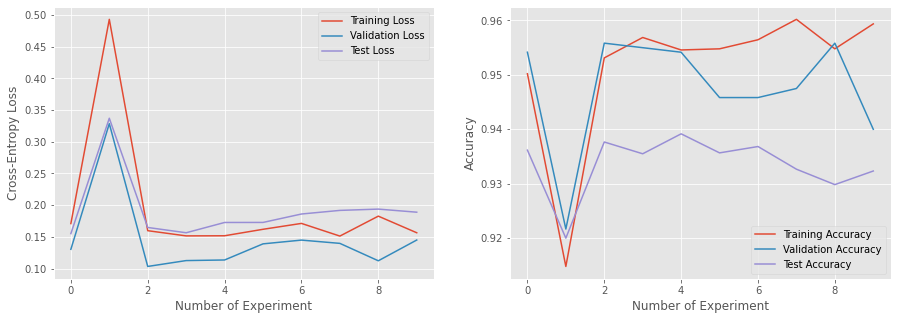

In [68]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.plot(test_loss,label='Test Loss')
plt.xlabel('Number of Experiment')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.plot(test_acc,label='Test Accuracy')
plt.xlabel('Number of Experiment')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## ANN Results

Belwo the results for the ANN are generated.

In [69]:
f = pd.get_dummies(features)

model = Sequential()

model.add(Dense(15, activation='relu')) # len(x_wd.T)
model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.01))
opt = tf.keras.optimizers.Adam(learning_rate=0.002) #5e-4

x_train, x_test, y_train, y_test = train_test_split(x_wd,f, test_size = 0.2, shuffle=True)

x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=400, batch_size=50)

Epoch 1/400
96/96 [==============================] - 2s 6ms/step - loss: 0.8835 - accuracy: 0.5822 - val_loss: 0.5186 - val_accuracy: 0.7508
Epoch 2/400
96/96 [==============================] - 0s 3ms/step - loss: 0.5720 - accuracy: 0.7577 - val_loss: 0.4071 - val_accuracy: 0.8342
Epoch 3/400
96/96 [==============================] - 0s 3ms/step - loss: 0.4978 - accuracy: 0.8239 - val_loss: 0.3434 - val_accuracy: 0.8600
Epoch 4/400
96/96 [==============================] - 1s 5ms/step - loss: 0.4072 - accuracy: 0.8486 - val_loss: 0.2975 - val_accuracy: 0.8842
Epoch 5/400
96/96 [==============================] - 0s 4ms/step - loss: 0.3446 - accuracy: 0.8845 - val_loss: 0.2807 - val_accuracy: 0.8925
Epoch 6/400
96/96 [==============================] - 0s 5ms/step - loss: 0.3390 - accuracy: 0.8779 - val_loss: 0.2618 - val_accuracy: 0.9008
Epoch 7/400
96/96 [==============================] - 0s 5ms/step - loss: 0.3464 - accuracy: 0.8852 - val_loss: 0.2664 - val_accuracy: 0.8833
Epoch 8/400
9

Epoch 59/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2002 - accuracy: 0.9401 - val_loss: 0.1568 - val_accuracy: 0.9400
Epoch 60/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1809 - accuracy: 0.9388 - val_loss: 0.1500 - val_accuracy: 0.9417
Epoch 61/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2247 - accuracy: 0.9345 - val_loss: 0.1454 - val_accuracy: 0.9392
Epoch 62/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2095 - accuracy: 0.9461 - val_loss: 0.1520 - val_accuracy: 0.9400
Epoch 63/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1913 - accuracy: 0.9396 - val_loss: 0.1461 - val_accuracy: 0.9425
Epoch 64/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1805 - accuracy: 0.9403 - val_loss: 0.1602 - val_accuracy: 0.9400
Epoch 65/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2139 - accuracy: 0.9375 - val_loss: 0.1451 - val_accuracy: 0.9442
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.2091 - accuracy: 0.9447 - val_loss: 0.1392 - val_accuracy: 0.9483
Epoch 117/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1855 - accuracy: 0.9440 - val_loss: 0.1387 - val_accuracy: 0.9417
Epoch 118/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2102 - accuracy: 0.9415 - val_loss: 0.1374 - val_accuracy: 0.9467
Epoch 119/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1675 - accuracy: 0.9492 - val_loss: 0.1378 - val_accuracy: 0.9475
Epoch 120/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1681 - accuracy: 0.9441 - val_loss: 0.1366 - val_accuracy: 0.9492
Epoch 121/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1550 - accuracy: 0.9463 - val_loss: 0.1403 - val_accuracy: 0.9408
Epoch 122/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1736 - accuracy: 0.9448 - val_loss: 0.1368 - val_accuracy: 0.9475
Epoch 123/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1768 - accuracy: 0.9515 - val_loss: 0.1385 - val_accuracy: 0.9383
Epoch 174/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1582 - accuracy: 0.9527 - val_loss: 0.1342 - val_accuracy: 0.9458
Epoch 175/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2004 - accuracy: 0.9480 - val_loss: 0.1315 - val_accuracy: 0.9492
Epoch 176/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1894 - accuracy: 0.9455 - val_loss: 0.1571 - val_accuracy: 0.9258
Epoch 177/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1565 - accuracy: 0.9519 - val_loss: 0.1335 - val_accuracy: 0.9425
Epoch 178/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1836 - accuracy: 0.9458 - val_loss: 0.1356 - val_accuracy: 0.9533
Epoch 179/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1874 - accuracy: 0.9449 - val_loss: 0.1324 - val_accuracy: 0.9442
Epoch 180/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1730 - accuracy: 0.9505 - val_loss: 0.1815 - val_accuracy: 0.9350
Epoch 231/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9345 - val_loss: 0.1374 - val_accuracy: 0.9425
Epoch 232/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1623 - accuracy: 0.9518 - val_loss: 0.1359 - val_accuracy: 0.9392
Epoch 233/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1791 - accuracy: 0.9514 - val_loss: 0.1374 - val_accuracy: 0.9442
Epoch 234/400
96/96 [==============================] - 1s 7ms/step - loss: 0.1769 - accuracy: 0.9532 - val_loss: 0.1423 - val_accuracy: 0.9400
Epoch 235/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2033 - accuracy: 0.9430 - val_loss: 0.1379 - val_accuracy: 0.9467
Epoch 236/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1723 - accuracy: 0.9556 - val_loss: 0.1392 - val_accuracy: 0.9475
Epoch 237/400

96/96 [==============================] - 0s 4ms/step - loss: 0.1912 - accuracy: 0.9486 - val_loss: 0.1418 - val_accuracy: 0.9400
Epoch 288/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1851 - accuracy: 0.9531 - val_loss: 0.1407 - val_accuracy: 0.9458
Epoch 289/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1784 - accuracy: 0.9489 - val_loss: 0.1459 - val_accuracy: 0.9467
Epoch 290/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1626 - accuracy: 0.9538 - val_loss: 0.1421 - val_accuracy: 0.9425
Epoch 291/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1638 - accuracy: 0.9556 - val_loss: 0.1427 - val_accuracy: 0.9392
Epoch 292/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1749 - accuracy: 0.9542 - val_loss: 0.1412 - val_accuracy: 0.9408
Epoch 293/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1580 - accuracy: 0.9543 - val_loss: 0.1426 - val_accuracy: 0.9392
Epoch 294/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1930 - accuracy: 0.9486 - val_loss: 0.1435 - val_accuracy: 0.9450
Epoch 345/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1709 - accuracy: 0.9505 - val_loss: 0.1415 - val_accuracy: 0.9458
Epoch 346/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1750 - accuracy: 0.9524 - val_loss: 0.1440 - val_accuracy: 0.9400
Epoch 347/400
96/96 [==============================] - ETA: 0s - loss: 0.1880 - accuracy: 0.94 - 0s 3ms/step - loss: 0.1879 - accuracy: 0.9484 - val_loss: 0.1505 - val_accuracy: 0.9450
Epoch 348/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1630 - accuracy: 0.9515 - val_loss: 0.1448 - val_accuracy: 0.9408
Epoch 349/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1793 - accuracy: 0.9510 - val_loss: 0.1378 - val_accuracy: 0.9442
Epoch 350/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2037 - accuracy: 0.9493 - val_loss: 0

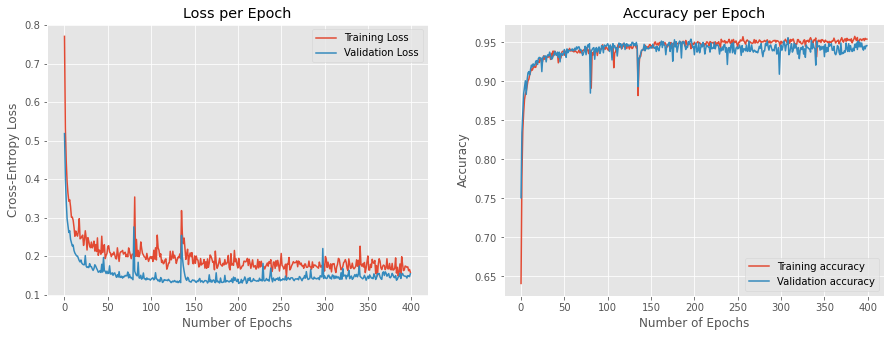

In [70]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'Training accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [71]:
yy_test = pd.get_dummies(yy)
results = model.evaluate(xx_dummy, yy_test, batch_size=128)
#y_hat = model.predict_classes(xx_dummy, verbose=1)
#y_hat_dummy = pd.get_dummies(y_hat)
print("test loss, test acc:", results)
#print(sklearn.metrics.f1_score(y_hat_dummy, yy_test,average='micro'))

47/47 [==============================] - 0s 3ms/step - loss: 0.1702 - accuracy: 0.9373
test loss, test acc: [0.17020632326602936, 0.937333345413208]


In [72]:
results[0]

0.17020632326602936

## Below the results for the Support Vector Machine are Generated

The label is transformed such that unsatisfied or neutral passengers are coded as -1 and satisfied passenger are coded as 1. 

In [73]:
svm_y = np.empty((len(features),1))

for i in range(len(features)):
    if features.iloc[i] == 1:
        svm_y[i] = 1
    else:
        svm_y[i] = -1

svm_y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)


clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training Accuracy:  0.9433333333333334
Validation Accuracy:  0.9341666666666667


### Get results for the Test data

In [74]:
svm_y_test = np.empty((len(yy),1))

for i in range(len(yy)):
    if yy.iloc[i] == 1:
        svm_y_test[i] = 1
    else:
        svm_y_test[i] = -1

In [75]:
y_pred = clf.predict(xx_dummy)
print('Test Accuracy: ',clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test,average='micro'))

Test Accuracy:  0.924
0.924


## Results for the Random Forest Classifier

In [76]:
clf = RandomForestClassifier(max_depth=None, random_state=0)

x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)

clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

<ipython-input-76-658d8ea662f0>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Training Accuracy:  1.0
Validation Accuracy:  0.9541666666666667


In [77]:
y_pred = clf.predict(xx_dummy)
print('Test Accuracy: ',clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

Test Accuracy:  0.9406666666666667
0.929893658920835


## Results for AdaBoost

In [78]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training Accuracy:  0.9339583333333333
Validation Accuracy:  0.9266666666666666
Test Accuracy:  0.38716666666666666
0.9142070051160961


## Results for Naive Bayes

In [79]:
clf = GaussianNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

Training Accuracy:  0.87125
Validation Accuracy:  0.8766666666666667
Test Accuracy:  0.35083333333333333
0.8282510328546134


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


## Results for QDA

In [80]:
clf = QDA()
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))

Training Accuracy:  0.6785416666666667
Validation Accuracy:  0.6975
Test Accuracy:  0.22


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## Results for Logistic Regression

In [81]:
x_train, x_test, y_train, y_test = train_test_split(x_wd,features, test_size = 0.2, shuffle=True)
clf = LogisticRegression(random_state=0,max_iter=500).fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, yy))

Training Accuracy:  0.879375
Validation Accuracy:  0.8791666666666667
Test Accuracy:  0.8631666666666666
0.8380989942812068
